# Project Settings

## Import libraries

In [140]:
import os
import datetime as dt
from operator import attrgetter

import helpers

# visualization
import matplotlib.pyplot as plt
# Optional - for dark them of graphs run the next line
plt.style.use("dark_background")

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns

# to print all the outputs in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy import stats
from scipy.stats import mode

# to show warnings only once:
import warnings; warnings.filterwarnings(action='once')

## Some additional settings

In [141]:
# adjusting columns width & number of chars
pd.set_option('display.width', 1200)
pd.set_option('max_colwidth', 500)

# set pandas max columns and rows to print
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# settings for Vizs
large = 22
med = 16
small = 12
params = {
    'axes.titlesize': large,
    'legend.fontsize': med,
    'figure.figsize': (17, 10),
    'axes.labelsize': med,
    'axes.titlesize': med,
    'xtick.labelsize': med,
    'ytick.labelsize': med,
    'figure.titlesize': large
}
plt.rcParams.update(params)
sns.set_style("white")
%matplotlib inline

In [142]:
pio.templates.default = "simple_white"

px.defaults.template = "plotly_dark"
px.defaults.color_continuous_scale = px.colors.sequential.Blackbody
px.defaults.width = 800
px.defaults.height = 500
color_discrete_sequence=px.colors.sequential.Oryel

## Download data

In [143]:
source_dir = './data/processed/'

# files to download:
file_users = 'users_processed.csv'
file_costs = 'costs_processed.csv'

In [144]:
df_users = pd.read_csv(os.path.join(source_dir, file_users)
                      #  ,nrows=500
                       ,parse_dates=['session_start_ts', 'session_end_ts', 'buy_ts']
                       ,dtype={'device': 'category', 'source_id': 'int'}
                       )

In [145]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373880 entries, 0 to 373879
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   uid                   373880 non-null  uint64        
 1   device                373880 non-null  category      
 2   source_id             373880 non-null  int32         
 3   session_start_ts      373880 non-null  datetime64[ns]
 4   session_end_ts        373880 non-null  datetime64[ns]
 5   buy_ts                50414 non-null   datetime64[ns]
 6   revenue               373880 non-null  float64       
 7   session_duration_sec  373880 non-null  int64         
dtypes: category(1), datetime64[ns](3), float64(1), int32(1), int64(1), uint64(1)
memory usage: 18.9 MB


## Step 1. Add additional variables to the model of user dataset

### Variables based on visits, registrations, and buying activities

*Add `first_session_ts`, and `first_visit_date`*

*Let's assume that the first `session_start_ts` is the first user's visit and registration datetime*

In [146]:
_users = df_users.groupby('uid')['session_start_ts'].agg(['min']).reset_index()
_users.columns = ['uid', 'first_session_ts']

In [147]:
df_users = df_users.merge(_users, how='left', on='uid')

*Add visit date  of `session_start_ts` and the first visit date based on the `first_session_ts`*

In [148]:
df_users['visit_date'] = helpers.get_day(df_users, 'session_start_ts')
df_users['first_visit_date'] = helpers.get_day(df_users, 'first_session_ts')

*Add `first_purchase_date` and virables based on it*

In [149]:
_buyers = df_users.groupby('uid')['buy_ts'].agg(['min']).reset_index()
_buyers.columns = ['uid', 'first_buy_ts']

In [150]:
df_users = df_users.merge(_buyers, how='left', on='uid')

In [151]:
df_users['order_date'] = helpers.get_day(df_users, 'buy_ts')
df_users['first_order_date'] = helpers.get_day(df_users, 'first_buy_ts')

### Add indicators (flags) based on the visits, first purchases

In [152]:
df_users['is_new_user'] = (df_users['first_session_ts'] == df_users['session_start_ts']) * 1
df_users['is_new_buyer'] = (df_users['first_buy_ts'] == df_users['buy_ts']) * 1
df_users['is_bought'] = ~df_users['buy_ts'].isna() * 1

*Test Sample*

In [153]:
df_users[df_users['uid'] == 618178059910673496].sort_values(by='session_start_ts')
# df_users[df_users['uid'] == 6444568725642094739].sort_values(by='session_start_ts')

,uid,device,source_id,session_start_ts,session_end_ts,buy_ts,revenue,session_duration_sec,first_session_ts,visit_date,first_visit_date,first_buy_ts,order_date,first_order_date,is_new_user,is_new_buyer,is_bought
71897,618178059910673496,browser,1,2017-12-23 00:08:00,2017-12-23 00:16:00,NaT,0.00,480,2017-12-23 00:08:00,2017-12-23,2017-12-23,2017-12-24 11:52:00,NaT,2017-12-24,1,0,0
366152,618178059910673496,unknown,0,2017-12-24 11:52:00,2017-12-24 11:52:00,2017-12-24 11:52:00,3.67,0,2017-12-23 00:08:00,2017-12-24,2017-12-23,2017-12-24 11:52:00,2017-12-24,2017-12-24,0,1,1
366714,618178059910673496,unknown,0,2018-01-02 11:10:00,2018-01-02 11:10:00,2018-01-02 11:10:00,4.03,0,2017-12-23 00:08:00,2018-01-02,2017-12-23,2017-12-24 11:52:00,2018-01-02,2017-12-24,0,0,1


### Variables based on session duration

In [154]:
df_users['session_duration_sec'].describe()

df_users['session_duration_sec'].mode()

count    373880.000000
mean        444.151150
std         506.931834
min           0.000000
25%          60.000000
50%         240.000000
75%         660.000000
max        2220.000000
Name: session_duration_sec, dtype: float64

0    60
Name: session_duration_sec, dtype: int64

<Axes: >

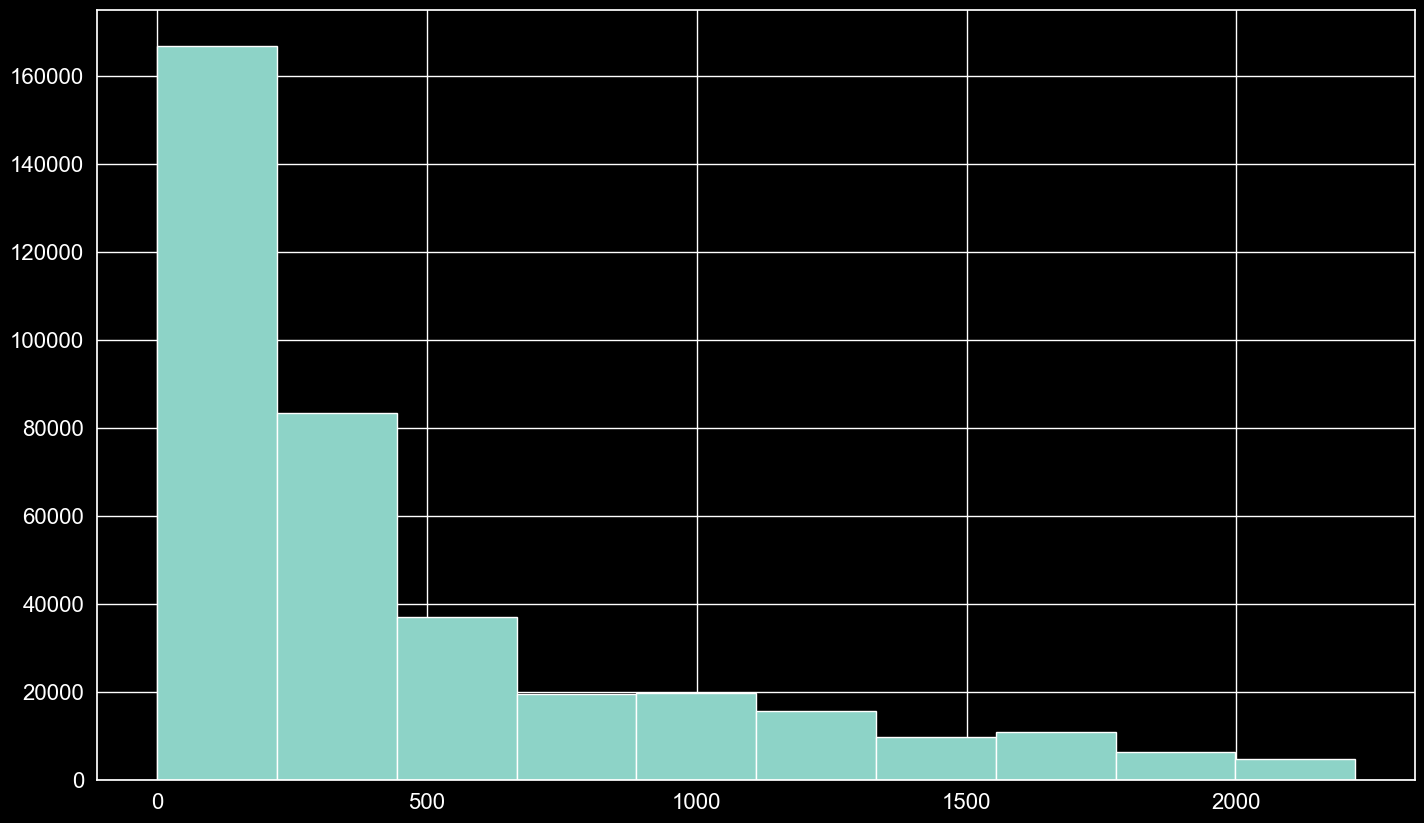

In [155]:
# plt.rcParams['figure.facecolor'] = 'gray'
plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')
# plt.style.use('bmh')

df_users['session_duration_sec'].hist()

*Add baseline session duration categories of session duratioin*

In [156]:
df_users['session_dur_category'] = pd.cut(df_users['session_duration_sec'], 
                                          bins=[0, 60.0, 240.0, 444.16, 660.0, float("inf")], 
                                          right=False)

df_users['session_category_name'] = pd.cut(df_users['session_duration_sec'], 
                                           bins=[0, 60.0, 240.0, 444.16, 660.0, float("inf")], 
                                           right=False,
                                           labels=['up to 1 minute', 'between 1 and 4 minutes', 'between 4 and 7.4 minutes', 'between 7.4 and 10 minutes', 'more than 10 minutes'])

*Calculate the time difference between the first visit and the first purchase*

<Axes: >

count    111881.000000
mean      25342.684281
std       30201.460906
min           0.000000
25%         600.000000
50%        8520.000000
75%       51960.000000
max       86340.000000
Name: time_diff_1st_visit_1st_puchase_sec, dtype: float64

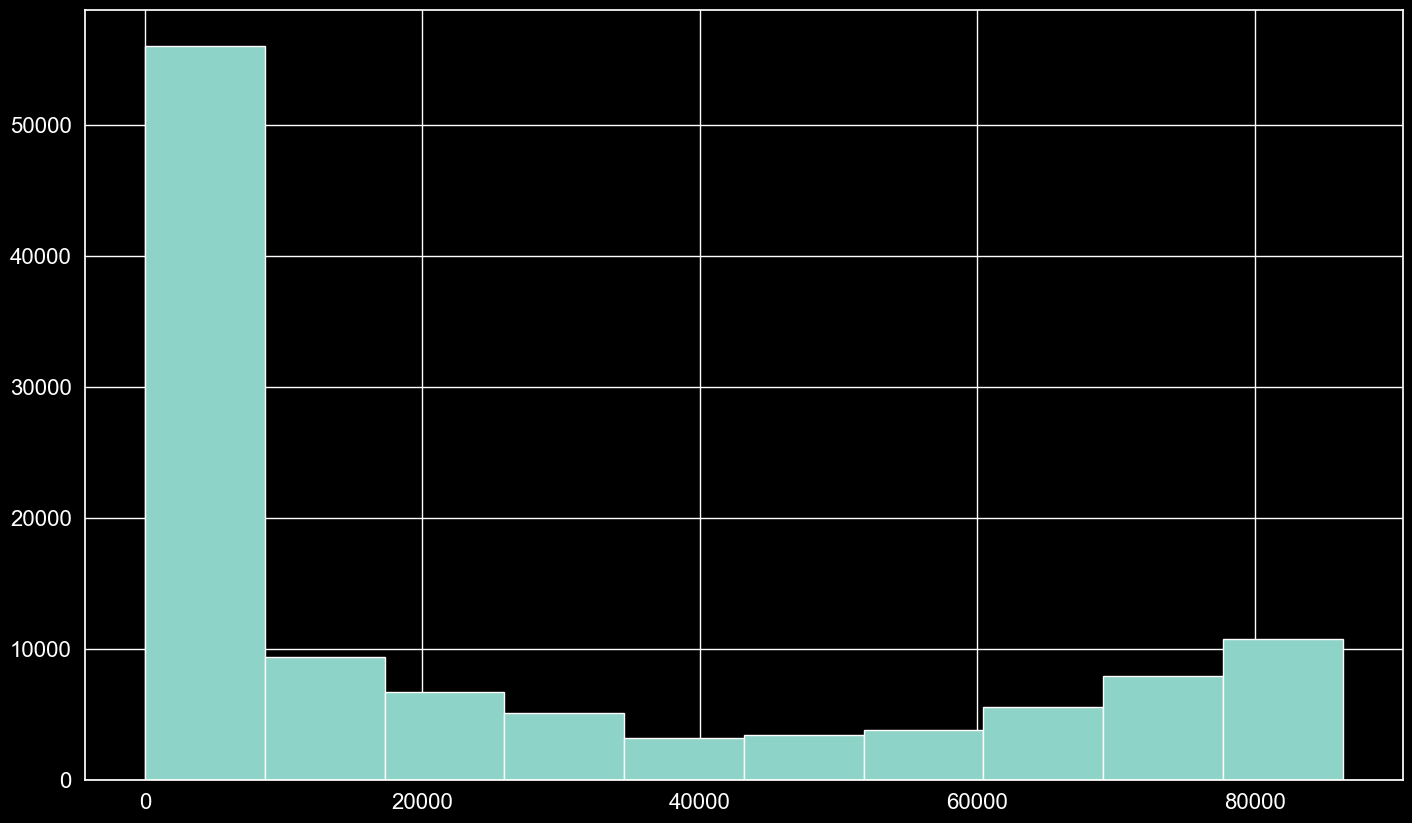

In [157]:
df_users['time_diff_1st_visit_1st_puchase_sec'] = helpers.time_diff(df_users['first_buy_ts'], df_users['first_session_ts'], 'seconds')
df_users['time_diff_1st_visit_1st_puchase_sec'].hist()
df_users['time_diff_1st_visit_1st_puchase_sec'].describe()

In [158]:
df_users.sample(10)

,uid,device,source_id,session_start_ts,session_end_ts,buy_ts,revenue,session_duration_sec,first_session_ts,visit_date,first_visit_date,first_buy_ts,order_date,first_order_date,is_new_user,is_new_buyer,is_bought,session_dur_category,session_category_name,time_diff_1st_visit_1st_puchase_sec
53312,180338321814157109,browser,4,2017-10-16 12:20:00,2017-10-16 12:24:00,NaT,0.00,240,2017-10-16 12:20:00,2017-10-16,2017-10-16,NaT,NaT,NaT,1,0,0,"[240.0, 444.16)",between 4 and 7.4 minutes,NaN
64253,6649342322994986622,browser,2,2017-09-14 12:36:00,2017-09-14 12:37:00,NaT,0.00,60,2017-09-14 12:36:00,2017-09-14,2017-09-14,2018-02-10 15:15:00,NaT,2018-02-10,1,0,0,"[60.0, 240.0)",between 1 and 4 minutes,9540.0
28195,3240128128737960704,browser,2,2018-04-09 23:36:00,2018-04-09 23:42:00,NaT,0.00,360,2017-11-17 21:04:00,2018-04-09,2017-11-17,NaT,NaT,NaT,0,0,0,"[240.0, 444.16)",between 4 and 7.4 minutes,NaN
69530,3644482766749211722,browser,5,2017-12-06 12:07:00,2017-12-06 12:25:00,2017-12-06 12:17:00,1.53,1080,2017-06-01 09:22:00,2017-12-06,2017-06-01,2017-06-01 09:22:00,2017-12-06,2017-06-01,0,0,1,"[660.0, inf)",more than 10 minutes,0.0
78526,4521719992477812448,mobile,1,2018-05-12 17:27:00,2018-05-12 17:27:00,NaT,0.00,0,2018-05-12 09:41:00,2018-05-12,2018-05-12,NaT,NaT,NaT,0,0,0,"[0.0, 60.0)",up to 1 minute,NaN
177722,14204273903417603832,browser,4,2017-11-14 09:07:00,2017-11-14 09:18:00,NaT,0.00,660,2017-11-14 09:07:00,2017-11-14,2017-11-14,NaT,NaT,NaT,1,0,0,"[660.0, inf)",more than 10 minutes,NaN
5643,13551952738594011920,browser,1,2017-07-25 10:55:00,2017-07-25 11:00:00,NaT,0.00,300,2017-06-01 10:05:00,2017-07-25,2017-06-01,2017-06-07 17:31:00,NaT,2017-06-07,0,0,0,"[240.0, 444.16)",between 4 and 7.4 minutes,26760.0
164867,3446546310772190636,mobile,3,2017-07-11 10:36:00,2017-07-11 10:50:00,2017-07-11 10:49:00,3.67,840,2017-07-11 10:36:00,2017-07-11,2017-07-11,2017-07-11 10:49:00,2017-07-11,2017-07-11,1,1,1,"[660.0, inf)",more than 10 minutes,780.0
101841,501046456229065346,mobile,4,2018-01-10 12:55:00,2018-01-10 12:56:00,NaT,0.00,60,2018-01-10 12:55:00,2018-01-10,2018-01-10,NaT,NaT,NaT,1,0,0,"[60.0, 240.0)",between 1 and 4 minutes,NaN
295379,5342067285161169772,browser,1,2018-02-12 10:28:00,2018-02-12 10:32:00,NaT,0.00,240,2018-02-01 11:46:00,2018-02-12,2018-02-01,2018-02-01 15:57:00,NaT,2018-02-01,0,0,0,"[240.0, 444.16)",between 4 and 7.4 minutes,15060.0


### Variables based on the revenue distribution

count    373880.000000
mean          0.434115
std           1.486620
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.750000
Name: revenue, dtype: float64

0    0.0
Name: revenue, dtype: float64

<Axes: >

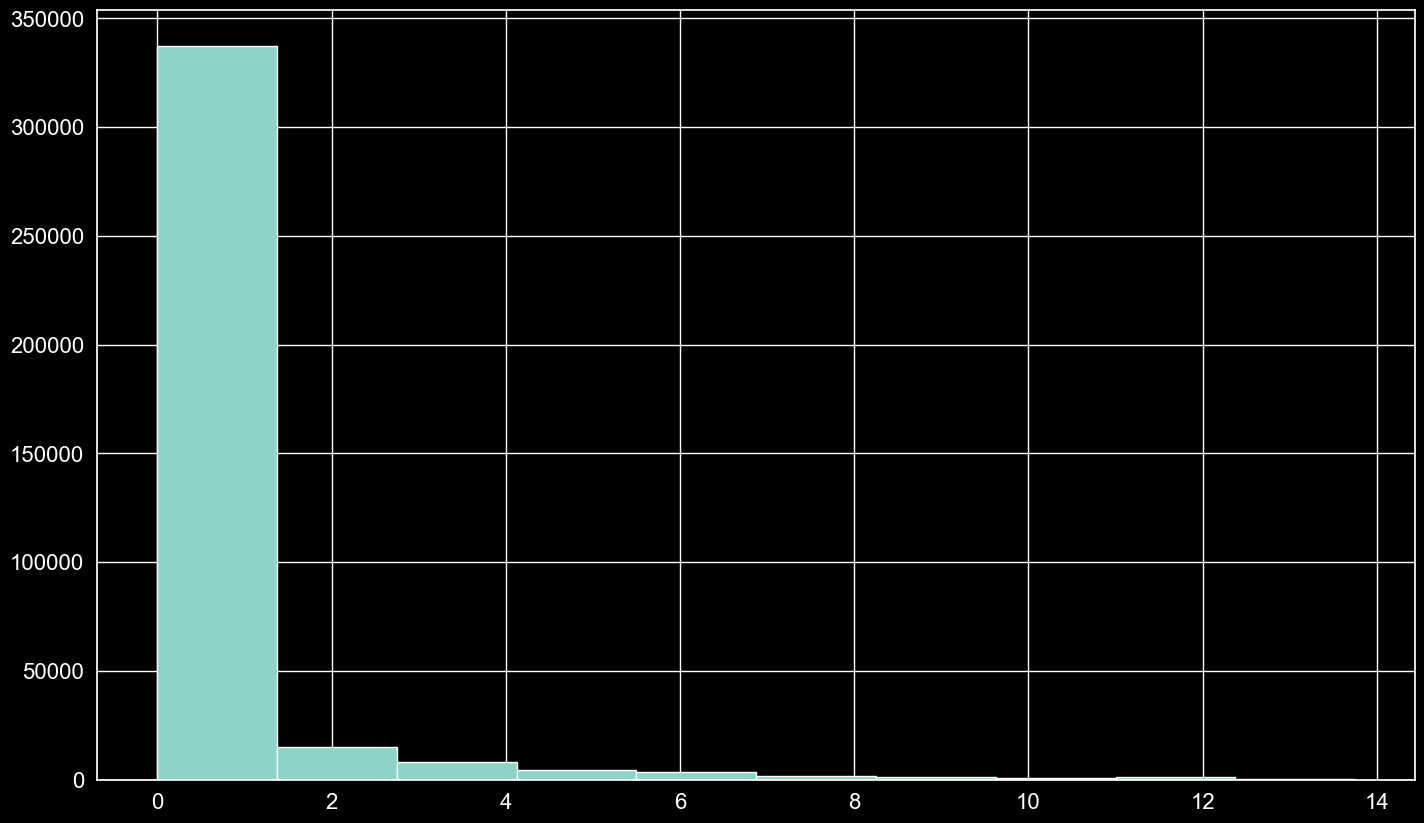

In [159]:
df_users['revenue'].describe()
df_users['revenue'].mode()

df_users['revenue'].hist()

In [160]:
df_users[df_users['revenue']>0]['revenue'].describe()
df_users[df_users['revenue']>0]['revenue'].mode()

count    50363.000000
mean         3.222745
std          2.723918
min          0.010000
25%          1.220000
50%          2.440000
75%          4.280000
max         13.750000
Name: revenue, dtype: float64

0    1.83
Name: revenue, dtype: float64

<Axes: >

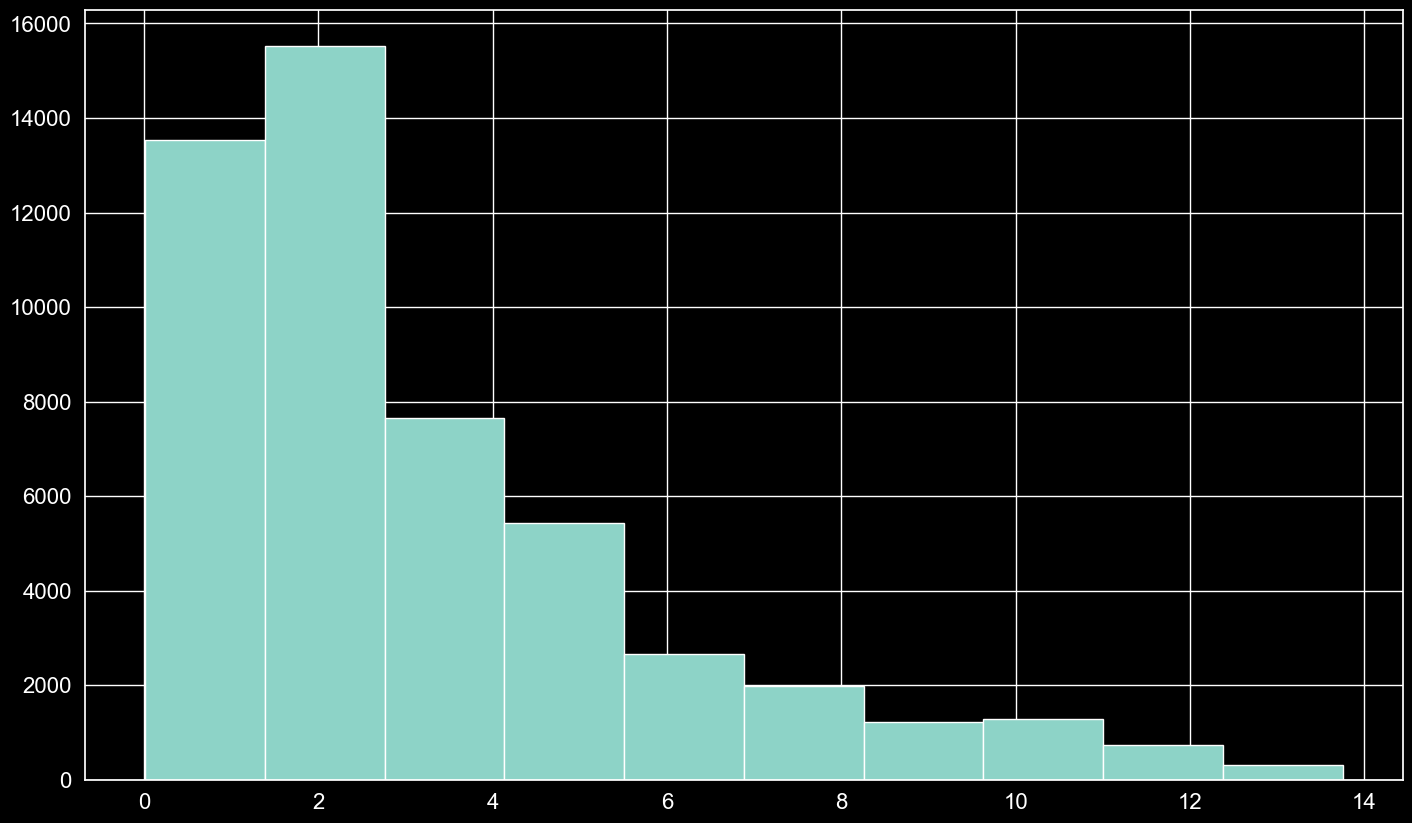

In [161]:
df_users[df_users['revenue']>0]['revenue'].hist()

In [162]:
df_users['revenue_mean'] = df_users['revenue'].mean().round(3)

df_users['revenue_category'] = pd.cut(df_users['revenue'], 
                                          bins=[-float("inf"), 0.0, 1.22, 1.83, 2.44, 4.28, float("inf")], 
                                          right=True)


In [163]:
df_users[df_users['uid'] == 618178059910673496].sort_values(by='session_start_ts')

,uid,device,source_id,session_start_ts,session_end_ts,buy_ts,revenue,session_duration_sec,first_session_ts,visit_date,first_visit_date,first_buy_ts,order_date,first_order_date,is_new_user,is_new_buyer,is_bought,session_dur_category,session_category_name,time_diff_1st_visit_1st_puchase_sec,revenue_mean,revenue_category
71897,618178059910673496,browser,1,2017-12-23 00:08:00,2017-12-23 00:16:00,NaT,0.00,480,2017-12-23 00:08:00,2017-12-23,2017-12-23,2017-12-24 11:52:00,NaT,2017-12-24,1,0,0,"[444.16, 660.0)",between 7.4 and 10 minutes,42240.0,0.434,"(-inf, 0.0]"
366152,618178059910673496,unknown,0,2017-12-24 11:52:00,2017-12-24 11:52:00,2017-12-24 11:52:00,3.67,0,2017-12-23 00:08:00,2017-12-24,2017-12-23,2017-12-24 11:52:00,2017-12-24,2017-12-24,0,1,1,"[0.0, 60.0)",up to 1 minute,42240.0,0.434,"(2.44, 4.28]"
366714,618178059910673496,unknown,0,2018-01-02 11:10:00,2018-01-02 11:10:00,2018-01-02 11:10:00,4.03,0,2017-12-23 00:08:00,2018-01-02,2017-12-23,2017-12-24 11:52:00,2018-01-02,2017-12-24,0,0,1,"[0.0, 60.0)",up to 1 minute,42240.0,0.434,"(2.44, 4.28]"


## Step 2. Make reports and calculate metrics.
Plot graphs to display how these metrics differ for various devices and ad sources and how they change in time.

### 2.1 Create analytical table based on user daily activities by aggregating the `df_users`

In [164]:
# list(df_users.columns)

In [165]:
at_users_daily = df_users.groupby([
    'visit_date'      
 ]).agg({
    'uid' : 'nunique'
    ,'session_start_ts': 'count'
    ,'buy_ts': 'count'
    ,'revenue': 'sum'
    ,'session_duration_sec': 'sum'
    ,'is_new_user': 'sum'    
    ,'is_new_buyer': 'sum'
    ,'is_bought': 'sum'  
    ,'time_diff_1st_visit_1st_puchase_sec': 'mean'
}).reset_index().sort_values(by=['visit_date'])

In [166]:
at_users_daily.sample()

,visit_date,uid,session_start_ts,buy_ts,revenue,session_duration_sec,is_new_user,is_new_buyer,is_bought,time_diff_1st_visit_1st_puchase_sec
85,2017-08-25,511,541,57,202.3,212558,373,48,57,21003.428571


In [167]:
at_users_daily = at_users_daily.rename(columns={
                    'uid': 'dau'
                    ,'session_start_ts': 'sessions_count'
                    ,'buy_ts': 'orders_count'
                    ,'revenue': 'revenue_sum'
                    ,'session_duration_sec': 'session_duration_sec_sum'
                    ,'is_new_user': 'is_new_user_sum'
                    ,'is_new_buyer': 'is_new_buyer_sum'
                    ,'is_bought': 'n_buyers'
                    ,'time_diff_1st_visit_1st_puchase_sec': 'diff_1st_visit_1st_purchase_mean_sec'
                    }
                      )


In [168]:
at_users_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   visit_date                            364 non-null    datetime64[ns]
 1   dau                                   364 non-null    int64         
 2   sessions_count                        364 non-null    int64         
 3   orders_count                          364 non-null    int64         
 4   revenue_sum                           364 non-null    float64       
 5   session_duration_sec_sum              364 non-null    int64         
 6   is_new_user_sum                       364 non-null    int32         
 7   is_new_buyer_sum                      364 non-null    int32         
 8   n_buyers                              364 non-null    int32         
 9   diff_1st_visit_1st_purchase_mean_sec  363 non-null    float64       
dtypes:

Test control data after merging

In [169]:
df_users['revenue'].sum()
at_users_daily['revenue_sum'].sum()

df_users['session_start_ts'].count()
at_users_daily['sessions_count'].sum()

162307.1

162307.1

373880

373880

In [170]:
at_users_daily['diff_1st_visit_1st_purchase_mean_sec'] = at_users_daily['diff_1st_visit_1st_purchase_mean_sec'].round(0)

*Add variables weekday, dayofweek, month and year based on the date*

In [171]:
at_users_daily['visit_weekday'] = at_users_daily['visit_date'].dt.day_name()
at_users_daily['weekday_num'] = at_users_daily['visit_date'].dt.dayofweek

at_users_daily['visit_week_num'] = at_users_daily['visit_date'].dt.isocalendar().week
at_users_daily['week_start_monday'] = at_users_daily["visit_date"].dt.to_period('W').dt.start_time

at_users_daily['visit_month'] = helpers.get_month(at_users_daily['visit_date'])
at_users_daily['visit_year'] = at_users_daily['visit_date'].dt.isocalendar().year

In [172]:
at_users_daily

,visit_date,dau,sessions_count,orders_count,revenue_sum,session_duration_sec_sum,is_new_user_sum,is_new_buyer_sum,n_buyers,diff_1st_visit_1st_purchase_mean_sec,visit_weekday,weekday_num,visit_week_num,week_start_monday,visit_month,visit_year
0,2017-06-01,605,678,96,249.62,305817,605,86,96,22654.0,Thursday,3,22,2017-05-29,2017-06-01,2017
1,2017-06-02,611,674,111,274.35,307055,564,97,111,19472.0,Friday,4,22,2017-05-29,2017-06-01,2017
2,2017-06-03,447,487,68,170.15,208159,411,58,68,23657.0,Saturday,5,22,2017-05-29,2017-06-01,2017
3,2017-06-04,481,521,66,145.63,219278,441,55,66,20034.0,Sunday,6,22,2017-05-29,2017-06-01,2017
4,2017-06-05,827,909,161,386.06,404334,746,140,161,23597.0,Monday,0,23,2017-06-05,2017-06-01,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,2018-05-27,635,701,107,317.28,298920,384,65,107,20383.0,Sunday,6,21,2018-05-21,2018-05-01,2018
360,2018-05-28,1067,1211,189,495.03,526939,629,130,189,23283.0,Monday,0,22,2018-05-28,2018-05-01,2018
361,2018-05-29,976,1098,187,457.82,490898,574,126,187,26573.0,Tuesday,1,22,2018-05-28,2018-05-01,2018
362,2018-05-30,1323,1479,210,524.09,664238,899,146,210,26918.0,Wednesday,2,22,2018-05-28,2018-05-01,2018


Add variables to analytical table

In [173]:
at_users_daily['num_sessions_per_user_mean'] = (at_users_daily['sessions_count'] / at_users_daily['dau']).round(2)

at_users_daily['num_orders_per_user_mean'] = (at_users_daily['orders_count'] / at_users_daily['dau']).round(2)

In [174]:
at_users_daily.head()

,visit_date,dau,sessions_count,orders_count,revenue_sum,session_duration_sec_sum,is_new_user_sum,is_new_buyer_sum,n_buyers,diff_1st_visit_1st_purchase_mean_sec,visit_weekday,weekday_num,visit_week_num,week_start_monday,visit_month,visit_year,num_sessions_per_user_mean,num_orders_per_user_mean
0,2017-06-01,605,678,96,249.62,305817,605,86,96,22654.0,Thursday,3,22,2017-05-29,2017-06-01,2017,1.12,0.16
1,2017-06-02,611,674,111,274.35,307055,564,97,111,19472.0,Friday,4,22,2017-05-29,2017-06-01,2017,1.10,0.18
2,2017-06-03,447,487,68,170.15,208159,411,58,68,23657.0,Saturday,5,22,2017-05-29,2017-06-01,2017,1.09,0.15
3,2017-06-04,481,521,66,145.63,219278,441,55,66,20034.0,Sunday,6,22,2017-05-29,2017-06-01,2017,1.08,0.14
4,2017-06-05,827,909,161,386.06,404334,746,140,161,23597.0,Monday,0,23,2017-06-05,2017-06-01,2017,1.10,0.19


### 2.2 Product metrics

User engagement metric: DAU, WAU, MAU

`DAU - the number of daily active unique users`

`A mean DAU`

In [175]:
at_users_daily['dau'].mean().astype(int)

930

In [176]:
fig = px.line(
              at_users_daily
              ,x='visit_date'
              ,y='dau'
              ,title='DAU - the number of daily active unique users'
              ,labels={
                    'visit_date': ''
                    ,'dau': ''
              }
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white'))

`DAU vs New users`

In [177]:
fig = px.line(
              at_users_daily
              ,x='visit_date'
              ,y=['dau', 'is_new_user_sum']
              ,title='DAU vs New users'
              ,labels={
                    'visit_date': ''
                    ,'dau': ''
              }
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white'))

> DAU metric

- As we can see from the DAU metric, the daily amount of visitors does not remain constant over the year
- Average daily visits - **930** users.
- In addition, the number of active (unique) users rose sharply on November 24, 2017, it was a Black Friday.
- And visits suddenly and significantly decreased on March 31, 2018. It can be assumed that this happened for some external reasons. For example, the famous [football match "Spartak Moscow" - "Tosnun" was held on March 31, 2018].(https://www.eurosport.com/football/russian-premier-league/2017-2018/live-spartak-moscow-fc-tosno_mtc956622/live.shtml)
- It also seems like there is a weekly sharp drop that depends on the day of the week.

`WAU - the number of weekly active unique users`

In [178]:

df_users['visit_weekday'] = df_users['visit_date'].dt.day_name()
df_users['weekday_num'] = df_users['visit_date'].dt.dayofweek

df_users['visit_week_num'] = df_users['visit_date'].dt.isocalendar().week
df_users['week_start_monday'] = df_users["visit_date"].dt.to_period('W').dt.start_time

df_users['visit_month'] = helpers.get_month(df_users['visit_date'])
df_users['visit_year'] = df_users['visit_date'].dt.isocalendar().year

In [179]:
wau = df_users.groupby('week_start_monday')['uid'].nunique().reset_index().rename(columns={'uid': 'wau'})
wau['wau'].mean().astype(int)

5807

In [180]:
fig = px.bar(
    wau
    ,x='week_start_monday'
    ,y='wau'
    ,title='WAU - Weekly active users'
    ,labels={'wau': ''
             ,'week_start_monday': ''
             }
    # ,text='wau'
)
# fig.update_xaxes(showline=False, showgrid=False)
fig.update_yaxes(showline=False, showgrid=False)

In [181]:
_visit_weekday = (df_users.groupby(['visit_year', 'week_start_monday','visit_weekday', 'weekday_num'])
                  .agg({
                      'uid': 'nunique'
                      ,'session_start_ts': 'count'                      
                  })
                  .reset_index().rename(columns={'uid': 'nunique_users', 'session_start_ts': 'num_sessions'}).sort_values(by = ['weekday_num'])
                  )
_visit_weekday.head()                

,visit_year,week_start_monday,visit_weekday,weekday_num,nunique_users,num_sessions
285,2018,2018-03-12,Monday,0,1218,1361
33,2017,2017-07-03,Monday,0,607,651
340,2018,2018-05-07,Monday,0,737,818
145,2017,2017-10-23,Monday,0,1284,1416
75,2017,2017-08-14,Monday,0,496,533


In [182]:
fig = px.area(
    _visit_weekday    
    ,x='week_start_monday'
    ,y='nunique_users'
    ,title='WAU - Weekly active users by visit weekday'
    ,labels={'nunique_users': ''
             ,'visit_weekday': ''
             ,'week_start_monday': ''
             }
    ,color='visit_weekday'
)
fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False).update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')


In [183]:
_tmp_visit_weekday = (_visit_weekday.groupby(['visit_year', 'visit_weekday', 'weekday_num'])['nunique_users']
                      .mean().reset_index().rename(columns={'nunique_users': 'nunique_users_mean'}).sort_values(by=['visit_year', 'weekday_num']) )
_tmp_visit_weekday['nunique_users_mean'] = _tmp_visit_weekday['nunique_users_mean'].astype(int)
_tmp_visit_weekday

,visit_year,visit_weekday,weekday_num,nunique_users_mean
1,2017,Monday,0,952
5,2017,Tuesday,1,908
6,2017,Wednesday,2,884
4,2017,Thursday,3,934
0,2017,Friday,4,961
2,2017,Saturday,5,717
3,2017,Sunday,6,694
8,2018,Monday,0,1106
12,2018,Tuesday,1,1085
13,2018,Wednesday,2,1057


In [184]:
fig = px.bar(
    _tmp_visit_weekday
    ,x='visit_weekday'
    ,y='nunique_users_mean'
    ,title='Mean of active users by visit weekday'
    ,labels={'nunique_users_mean': ''
             ,'visit_weekday': ''
             ,'visit_year': ''
             }
    ,barmode="group"
    ,color='visit_year'
    ,text='nunique_users_mean'
    # ,color_discrete_sequence=px.colors.diverging.Spectral[-1::-2]

)
fig.update_yaxes(showgrid=False)

# fig.show()

> WAU metric
 
- An average weekly visits - 5807 users

- User activities depend on the day of the week

`MAU - Monthly visits`

In [185]:
mau = df_users.groupby(['visit_year','visit_month'])['uid'].nunique().reset_index().rename(columns={'uid': 'mau'})
mau['mau'].mean().astype(int)
mau

23469

,visit_year,visit_month,mau
0,2017,2017-06-01,13259
1,2017,2017-07-01,14237
2,2017,2017-08-01,11709
3,2017,2017-09-01,19111
4,2017,2017-10-01,29901
5,2017,2017-11-01,33055
6,2017,2017-12-01,31898
7,2018,2018-01-01,29064
8,2018,2018-02-01,29149
9,2018,2018-03-01,27911


In [186]:
fig = px.bar(
    mau
    ,x='visit_month'
    ,y='mau'
    ,title='MAU - Monthly active users'
    ,labels={'dau': ''
             ,'visit_month': ''
             ,'visit_year': ''
             }
    ,text='mau'
    ,color='visit_year'
)
fig.update_yaxes(showgrid=False).update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
# fig.show()

*MAU - Average monthly visits - 23469 users.*

>**Conclusion**

- Daily, weekly, and monthly user activities are 930, 5807, and 23469 respectively.

- There are dependencies of user activity on the day of the week, and on the month of year.

- Users were the most active on the 5 the day of the week, and in November and December.

- Less active users were on weekend, as well as in summer months.

- User visits are influenced by external factors such as international holidays and local events.

`User stickiness` - `DAU/MAU/MAU Ratio`

In [187]:
# DAU/WAU ratio

(at_users_daily['dau'].mean() / wau['wau'].mean() * 100).round(2)

# DAU/MAU ratio
(at_users_daily['dau'].mean() / mau['mau'].mean() * 100).round(2)

# WAU/MAU ratio
(wau['wau'].mean() / mau['mau'].mean() * 100).round(2)

16.02

3.96

24.74

Selecting the Right User Metric:

https://medium.com/sequoia-capital/selecting-the-right-user-metric-de95015aa38

* One important point to remember is that the ratio of daily active users to weekly active users (DAU/WAU) can never be less than 1/7 (14.29%)
* Additionally, the ratio of daily active users to monthly active users (DAU/MAU) can never be lower than 1/28 (35.71%) where MAU is calculated over 28 days. 
* Finally, the ratio of weekly active users to monthly active users (WAU/MAU) can never be below 1/4 (25%).* 

*If the DAU/WAU (daily active users/weekly active users) ratio is at least 60%, it indicates that the product is used more than four days per week, making it a daily usage product.*


So, in our project we recommend that to monitor user activity on a monthly basis. 

However, business stakeholders are interested in the day-to-day activities of users. Thet's why we should create an analytical table on the daily base.

#### 2.2 User's sessions

`How many sessions are there per day?`

(One user might have more than one session.)

In [188]:
at_users_daily['sessions_count'].mean().astype(int)

1027

In [189]:
fig = px.line(
    at_users_daily
    ,x='visit_date'
    ,y='sessions_count'
    ,title='Number of Daily user sessions'
    ,labels={
        'visit_date': ''
        ,'sessions_count': ''
    }
)
fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False).update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

# fig.show()

> *The average number of sessions per day is 1027. It's clear that the total number of sessions increases with increasing users and vs.*

`The dynamics of total sessions per day vs the dynamics of DAU`

In [190]:
fig = px.line(
    at_users_daily
    ,x='visit_date'
    ,y=['sessions_count', 'dau']
    ,title='Number of daily user sessions vs DAU'
    ,labels={
        'visit_date': ''
    }
)
fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False).update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

# fig.show()

> *The line chart shows that the number of sessions per day is almost the same as the number of visits.*

`Mean number of sessions per user`

In [191]:
at_users_daily['num_sessions_per_user_mean'].mean().round(3)

1.097

In [192]:
fig = px.line(
    at_users_daily
    ,x='visit_date'
    ,y='num_sessions_per_user_mean'
    ,title='Daily average number of sessions per user'
    ,labels={
        'visit_date': ''
        ,'num_sessions_per_user_mean': ''
    }
)
fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False).update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
# fig.update_yaxes(showgrid=False, rangemode="tozero")

>*Average daily sessions per user - 1.097*

The daily average number of sessions per user is from 1.03 to 1.27

On March 28 in 2018 the average number of sessions per user equals 1

`Average number of sesions by weekday`

In [193]:
_tmp = at_users_daily.groupby(['visit_year', 'weekday_num'])['sessions_count'].mean().reset_index().sort_values(by=['visit_year','weekday_num'])
_tmp['sessions_count'] = _tmp['sessions_count'].astype(int)
_tmp.rename(columns = {'sessions_count': 'sessions_count_mean'}, inplace=True)

In [194]:
fig = px.bar(
    _tmp
    ,x='weekday_num'
    ,y='sessions_count_mean'
    ,title='Average number of sessions by weekday'
    ,labels={'weekday_num': ''
             ,'visit_year': ''
             ,'sessions_count_mean': ''
             }
    ,barmode="group"
    ,color='visit_year'
    ,text='sessions_count_mean'
    # ,color_discrete_sequence=px.colors.diverging.Spectral[-1::-2]

)
fig.update_yaxes(visible=False, showgrid=False).update_xaxes(showgrid=False).update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

# fig.show()

>On weekends, the average number of sessions is less than on weekdays.

In [195]:
# list(at_users_daily.columns)
at_users_daily['session_duration_sec_mean'] = (at_users_daily['session_duration_sec_sum'] / at_users_daily['sessions_count']).astype(int)

In [196]:
at_users_daily.head()

,visit_date,dau,sessions_count,orders_count,revenue_sum,session_duration_sec_sum,is_new_user_sum,is_new_buyer_sum,n_buyers,diff_1st_visit_1st_purchase_mean_sec,visit_weekday,weekday_num,visit_week_num,week_start_monday,visit_month,visit_year,num_sessions_per_user_mean,num_orders_per_user_mean,session_duration_sec_mean
0,2017-06-01,605,678,96,249.62,305817,605,86,96,22654.0,Thursday,3,22,2017-05-29,2017-06-01,2017,1.12,0.16,451
1,2017-06-02,611,674,111,274.35,307055,564,97,111,19472.0,Friday,4,22,2017-05-29,2017-06-01,2017,1.10,0.18,455
2,2017-06-03,447,487,68,170.15,208159,411,58,68,23657.0,Saturday,5,22,2017-05-29,2017-06-01,2017,1.09,0.15,427
3,2017-06-04,481,521,66,145.63,219278,441,55,66,20034.0,Sunday,6,22,2017-05-29,2017-06-01,2017,1.08,0.14,420
4,2017-06-05,827,909,161,386.06,404334,746,140,161,23597.0,Monday,0,23,2017-06-05,2017-06-01,2017,1.10,0.19,444


`What is the average length of sessions per session per period?`

In [197]:
fig = px.line(
    at_users_daily
    ,x='visit_date'
    ,y='session_duration_sec_mean'
    ,title='Average length of sessions over time, seconds'
    ,labels={'visit_date': ''
             ,'session_duration_sec_mean': ''
             }
    ,color='visit_year'
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
)

`Number of sessions by device`

In [198]:
_sessions_by_device = df_users.groupby('device')['session_start_ts'].count().astype(int).reset_index()
_sessions_by_device

,device,session_start_ts
0,browser,262563
1,mobile,96829
2,unknown,14488


In [199]:
fig = px.bar(
    _sessions_by_device
    ,x='device'
    ,y='session_start_ts'
    ,title='Total number of sessions by device'
    ,labels={
        'device': ''
        ,'session_start_ts': ''
    }
    ,text='session_start_ts'
)
fig.show()

`Average number of sessions and session duration by device over time`

In [200]:
_sessions_by_device_over_time = (df_users.groupby(['visit_date', 'device'])
                                 .agg({
                                     'session_duration_sec': 'mean'
                                     ,'session_start_ts': 'count'
                                 }).reset_index().rename(columns={'session_start_ts': 'sessions_count'
                                                                  ,'session_duration_sec': 'session_duration_sec_mean'})
                              )
_sessions_by_device_over_time['session_duration_sec_mean'] = _sessions_by_device_over_time['session_duration_sec_mean'].fillna(0).astype(int)


In [201]:
_sessions_by_device_over_time.head()

,visit_date,device,session_duration_sec_mean,sessions_count
0,2017-06-01,browser,488,501
1,2017-06-01,mobile,375,163
2,2017-06-01,unknown,0,14
3,2017-06-02,browser,484,498
4,2017-06-02,mobile,411,160


In [202]:
fig = px.line(
    _sessions_by_device_over_time
    ,x='visit_date'
    ,y='sessions_count'
    ,title='Number of sessions by device over time'
    ,labels={'visit_date': ''
             ,'sessions_count': ''
             }
    ,color='device'
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
)

`Average length of sessions by device over time, seconds`

In [203]:
fig = px.line(
    _sessions_by_device_over_time
    ,x='visit_date'
    ,y='session_duration_sec_mean'
    ,title='Average length of sessions by device over time, seconds'
    ,labels={'visit_date': ''
             ,'session_duration_sec_mean': ''
             }
    ,color='device'
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
)

* The number of sessions in the "browser" is consistently higher compared to the "mobile" and "unknown" version.
* In addition, it was noticeable that the sessions in the "browser" version lasted about 100 seconds longer than in the "mobile" version.

`Number of sessions and unique users by session duration categoty name`

In [204]:
_session_category_name = df_users.groupby(['session_category_name']).agg({
    'uid': 'nunique'
    ,'session_start_ts': 'count'
}).reset_index().rename(columns = {
    'uid': 'nunique_users'
    ,'session_start_ts': 'sessions_count'})
_session_category_name

,session_category_name,nunique_users,sessions_count
0,up to 1 minute,41606,51150
1,between 1 and 4 minutes,95609,115449
2,between 4 and 7.4 minutes,64407,83370
3,between 7.4 and 10 minutes,25863,29187
4,more than 10 minutes,69301,94724


In [205]:
fig = px.bar(
    _session_category_name
    ,x='session_category_name'
    ,y=['sessions_count', 'nunique_users']
    ,title='Number of session by number of unique users and session duration category name'
    ,labels={'sessions_count': ''
             ,'session_category_name': ''
             ,
             }
    # ,text='sessions_count'
    ,barmode='group'
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
)

`Average daily sessions by source_id`

In [206]:
_sessions_source_id = df_users.groupby(['source_id']).agg({
   'session_duration_sec': 'mean'
   ,'session_start_ts': 'count'
}).reset_index().rename(columns={
   'session_duration_sec': 'session_duration_sec_mean'
   ,'session_start_ts': 'sessions_count'
   }).sort_values(by='source_id')
_sessions_source_id['session_duration_sec_mean'] = _sessions_source_id['session_duration_sec_mean'].astype(int)

_sessions_source_id

,source_id,session_duration_sec_mean,sessions_count
0,0,0,14488
1,1,602,34119
2,2,516,47626
3,3,434,85609
4,4,441,101792
5,5,422,66903
6,6,420,6
7,7,466,36
8,9,436,13277
9,10,469,10024


In [207]:
fig = px.bar(
    _sessions_source_id
    ,x='source_id'
    ,y='session_duration_sec_mean'
    ,title='Average session duration by source Id, seconds'
    ,labels={
        'source_id': ''
        ,'session_duration_sec_mean': ''
    }
    ,text='session_duration_sec_mean'
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
)

In [208]:
fig = px.bar(
    _sessions_source_id
    ,x='source_id'
    ,y='sessions_count'
    ,title='Total Sessions by source Id'
    ,labels={
        'source_id': ''
        ,'sessions_count': ''
    }
    ,text='sessions_count'
)
(fig.update_yaxes(showgrid=False).update_xaxes(showgrid=False)
 .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')
)

>Conclusion:

* The average number of sessions per day is 1076. And Average daily sessions per user - 1.097
* Visitors prefer the `browser` version to the `mobile` version.
* The amount of daily sessions differs depending on `source_id`.
* International holidays and local events affect the number of daily sessions as well as user visits.
* 4th and 3rd `source_id` have the most number of sessions for the entire period.
* Average daily session duration of 1st and 3rd `source_id` is noticeably longer.

#### 2.3 Cohorts & Retension

How often do users come back?

To answer this question we need to calculate the retention rate using cohort analysis. 

*We have data for a year, so it makes sense to build a cohort-based on monthly user activity.* 

`Cohorts Lifetime` 

https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

In [209]:
df_users['order_month'] = df_users['buy_ts'].dt.to_period('M')
df_users['cohort_month'] = df_users.groupby('uid')['buy_ts'].transform('min').dt.to_period('M') 

In [210]:
df_users.sample(10)

,uid,device,source_id,session_start_ts,session_end_ts,buy_ts,revenue,session_duration_sec,first_session_ts,visit_date,first_visit_date,first_buy_ts,order_date,first_order_date,is_new_user,is_new_buyer,is_bought,session_dur_category,session_category_name,time_diff_1st_visit_1st_puchase_sec,revenue_mean,revenue_category,visit_weekday,weekday_num,visit_week_num,week_start_monday,visit_month,visit_year,order_month,cohort_month
22909,15888195436327671492,browser,2,2017-12-05 22:32:00,2017-12-05 22:46:00,NaT,0.00,840,2017-12-05 22:32:00,2017-12-05,2017-12-05,NaT,NaT,NaT,1,0,0,"[660.0, inf)",more than 10 minutes,NaN,0.434,"(-inf, 0.0]",Tuesday,1,49,2017-12-04,2017-12-01,2017,NaT,NaT
226372,12233957121459025148,browser,3,2017-09-29 08:49:00,2017-09-29 08:50:00,NaT,0.00,60,2017-09-29 08:49:00,2017-09-29,2017-09-29,NaT,NaT,NaT,1,0,0,"[60.0, 240.0)",between 1 and 4 minutes,NaN,0.434,"(-inf, 0.0]",Friday,4,39,2017-09-25,2017-09-01,2017,NaT,NaT
362645,16827407102641624512,unknown,0,2017-10-21 14:48:00,2017-10-21 14:48:00,2017-10-21 14:48:00,3.05,0,2017-10-18 18:15:00,2017-10-21,2017-10-18,2017-10-21 14:48:00,2017-10-21,2017-10-21,0,1,1,"[0.0, 60.0)",up to 1 minute,73980.0,0.434,"(2.44, 4.28]",Saturday,5,42,2017-10-16,2017-10-01,2017,2017-10,2017-10
114774,13882450156872702595,browser,3,2018-01-04 14:24:00,2018-01-04 14:24:00,NaT,0.00,0,2018-01-04 14:24:00,2018-01-04,2018-01-04,NaT,NaT,NaT,1,0,0,"[0.0, 60.0)",up to 1 minute,NaN,0.434,"(-inf, 0.0]",Thursday,3,1,2018-01-01,2018-01-01,2018,NaT,NaT
256921,16270921295107010175,browser,4,2018-01-14 17:01:00,2018-01-14 17:02:00,NaT,0.00,60,2018-01-14 17:01:00,2018-01-14,2018-01-14,NaT,NaT,NaT,1,0,0,"[60.0, 240.0)",between 1 and 4 minutes,NaN,0.434,"(-inf, 0.0]",Sunday,6,2,2018-01-08,2018-01-01,2018,NaT,NaT
328567,4045631409247311468,browser,4,2017-08-14 16:15:00,2017-08-14 16:21:00,NaT,0.00,360,2017-08-14 16:15:00,2017-08-14,2017-08-14,NaT,NaT,NaT,1,0,0,"[240.0, 444.16)",between 4 and 7.4 minutes,NaN,0.434,"(-inf, 0.0]",Monday,0,33,2017-08-14,2017-08-01,2017,NaT,NaT
361727,5145690854965604178,unknown,0,2017-10-02 20:45:00,2017-10-02 20:45:00,2017-10-02 20:45:00,4.89,0,2017-07-28 00:27:00,2017-10-02,2017-07-28,2017-10-02 20:45:00,2017-10-02,2017-10-02,0,1,1,"[0.0, 60.0)",up to 1 minute,73080.0,0.434,"(4.28, inf]",Monday,0,40,2017-10-02,2017-10-01,2017,2017-10,2017-10
98680,13349959638622218184,browser,4,2017-12-04 13:35:00,2017-12-04 13:47:00,NaT,0.00,720,2017-12-04 13:35:00,2017-12-04,2017-12-04,NaT,NaT,NaT,1,0,0,"[660.0, inf)",more than 10 minutes,NaN,0.434,"(-inf, 0.0]",Monday,0,49,2017-12-04,2017-12-01,2017,NaT,NaT
301005,7603415947451640027,mobile,3,2017-11-07 00:17:00,2017-11-07 00:19:00,NaT,0.00,120,2017-11-07 00:17:00,2017-11-07,2017-11-07,NaT,NaT,NaT,1,0,0,"[60.0, 240.0)",between 1 and 4 minutes,NaN,0.434,"(-inf, 0.0]",Tuesday,1,45,2017-11-06,2017-11-01,2017,NaT,NaT
270425,6922331645844193404,browser,3,2017-07-18 18:16:00,2017-07-18 18:21:00,NaT,0.00,300,2017-07-18 18:16:00,2017-07-18,2017-07-18,NaT,NaT,NaT,1,0,0,"[240.0, 444.16)",between 4 and 7.4 minutes,NaN,0.434,"(-inf, 0.0]",Tuesday,1,29,2017-07-17,2017-07-01,2017,NaT,NaT


In [211]:
# df_users[df_users['uid'] == 17818797011639758931]

In [212]:
df_cohort = df_users.groupby(['cohort_month', 'order_month']) \
              .agg(n_users=('uid', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort_month).apply(attrgetter('n'))

In [213]:
df_cohort

,cohort_month,order_month,n_users,period_number
0,2017-06,2017-06,2023,0
1,2017-06,2017-07,61,1
2,2017-06,2017-08,50,2
3,2017-06,2017-09,54,3
4,2017-06,2017-10,88,4
...,...,...,...,...
73,2018-03,2018-04,90,1
74,2018-03,2018-05,58,2
75,2018-04,2018-04,2276,0
76,2018-04,2018-05,69,1


In [214]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort_month',
                                     columns = 'period_number',
                                     values = 'n_users')

In [215]:
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-06,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0
2017-07,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN,NaN
2017-09,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN,NaN,NaN
2017-10,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN,NaN,NaN,NaN
2017-11,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN,NaN,NaN,NaN,NaN
2017-12,4383.0,146.0,103.0,97.0,50.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,3373.0,114.0,83.0,43.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,3651.0,118.0,58.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='period_number', ylabel='cohort_month'>

Text(0.5, 1.0, 'Monthly Cohorts: User Buyers')

[Text(0.5, 49.249999999999986, '# of periods'),
 Text(299.44444444444446, 0.5, '')]

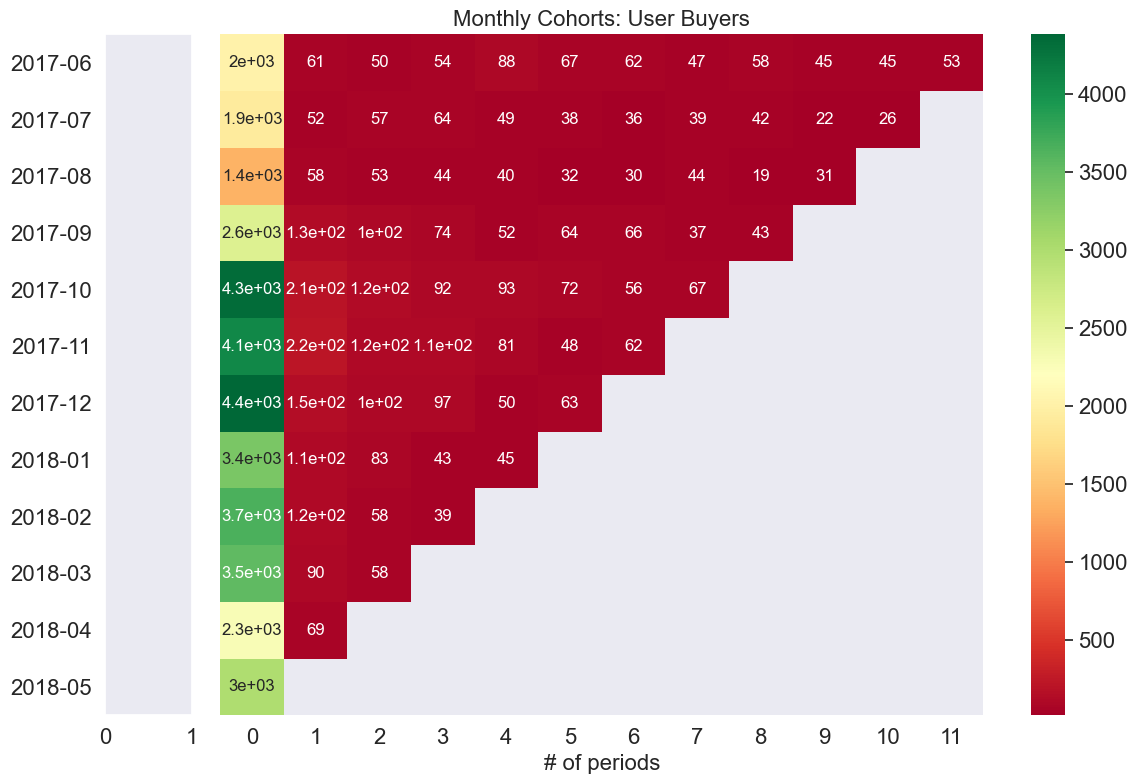

In [216]:

with sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(cohort_pivot, 
                mask=cohort_pivot.isnull(), 
                annot=True, 
                # fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Buyers', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    fig.tight_layout()

<Figure size 2000x1300 with 0 Axes>

Text(0.5, 1.0, 'Cohorts: monthly active users from each cohort')

<Axes: title={'center': 'Cohorts: monthly active users from each cohort'}, xlabel='period_number', ylabel='cohort_month'>

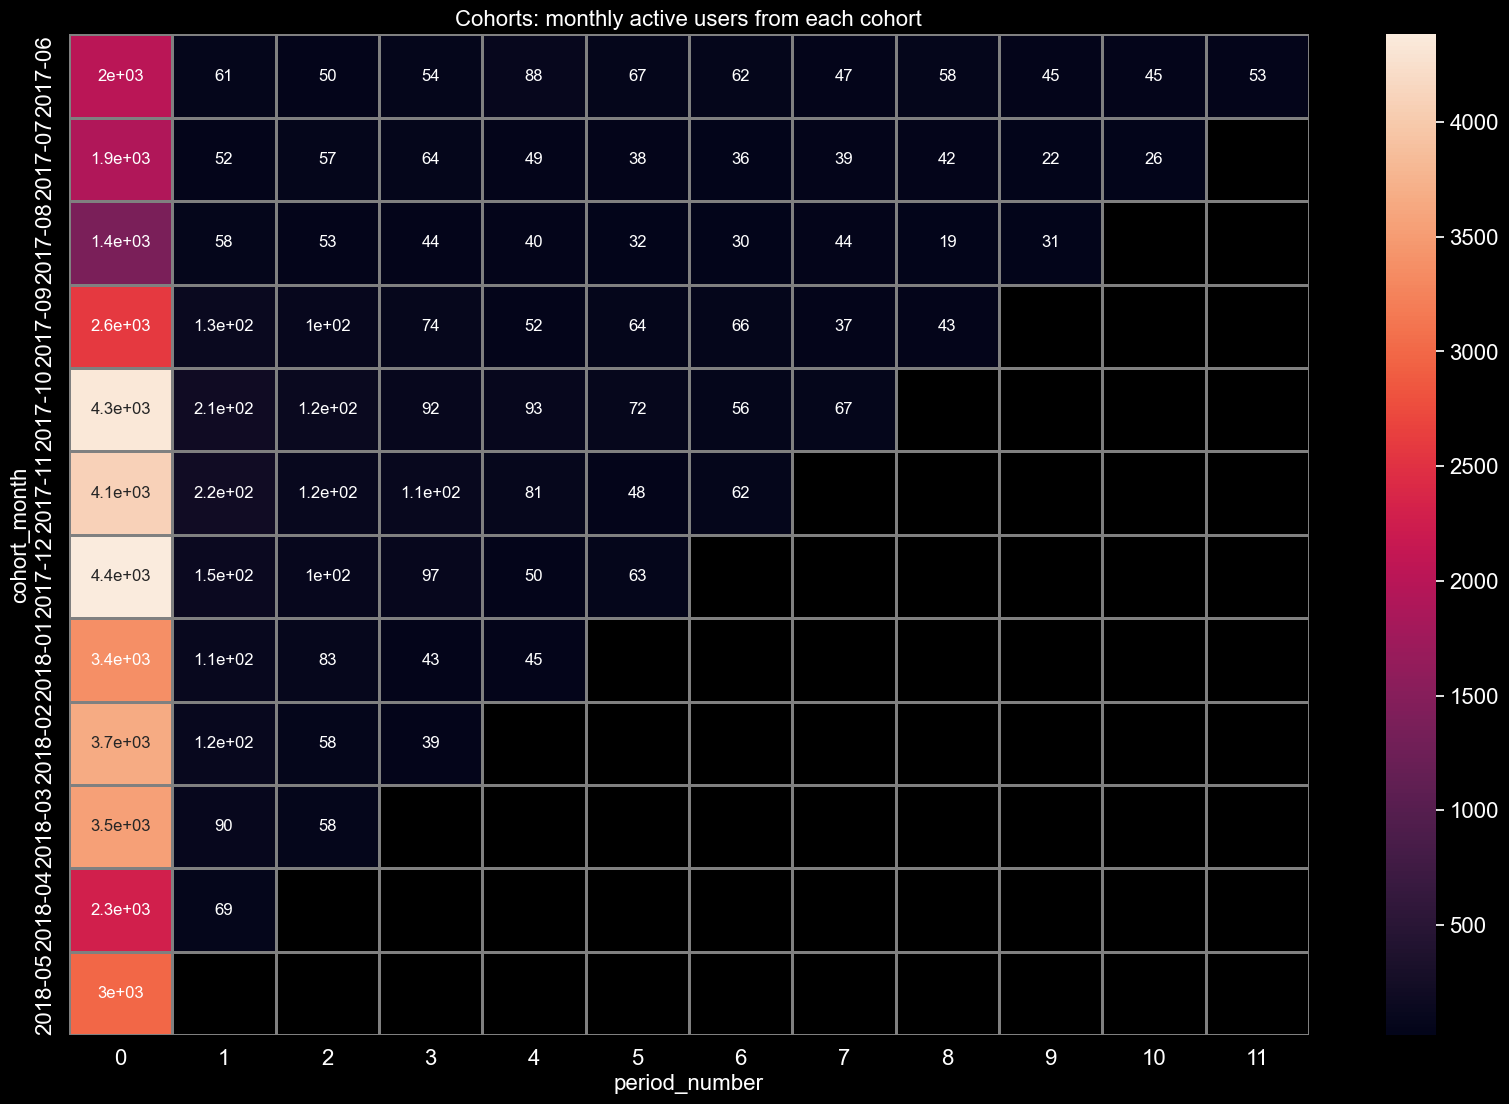

In [217]:
plt.figure(figsize=(20, 13))
plt.title('Cohorts: monthly active users from each cohort')
sns.heatmap(cohort_pivot,
            annot=True,
            # fmt='.1%',
            linewidths=1,
            linecolor='gray')

`Retention Rate calculation`

To obtain the retention matrix, we need to divide the values each row by the row's first value, which is actually the cohort size — all customers who made their first purchase in the given month.

In [218]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0).round(2)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2017-06,1.0,0.03,0.02,0.03,0.04,0.03,0.03,0.02,0.03,0.02,0.02,0.03
2017-07,1.0,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.01,0.01,NaN
2017-08,1.0,0.04,0.04,0.03,0.03,0.02,0.02,0.03,0.01,0.02,NaN,NaN
2017-09,1.0,0.05,0.04,0.03,0.02,0.02,0.03,0.01,0.02,NaN,NaN,NaN
2017-10,1.0,0.05,0.03,0.02,0.02,0.02,0.01,0.02,NaN,NaN,NaN,NaN
2017-11,1.0,0.05,0.03,0.03,0.02,0.01,0.02,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.03,0.02,0.02,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.03,0.02,0.01,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.03,0.02,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='period_number', ylabel='cohort_month'>

Text(0.5, 1.0, 'Monthly Cohorts: User Retention')

[Text(0.5, 49.249999999999986, '# of periods'),
 Text(299.44444444444446, 0.5, '')]

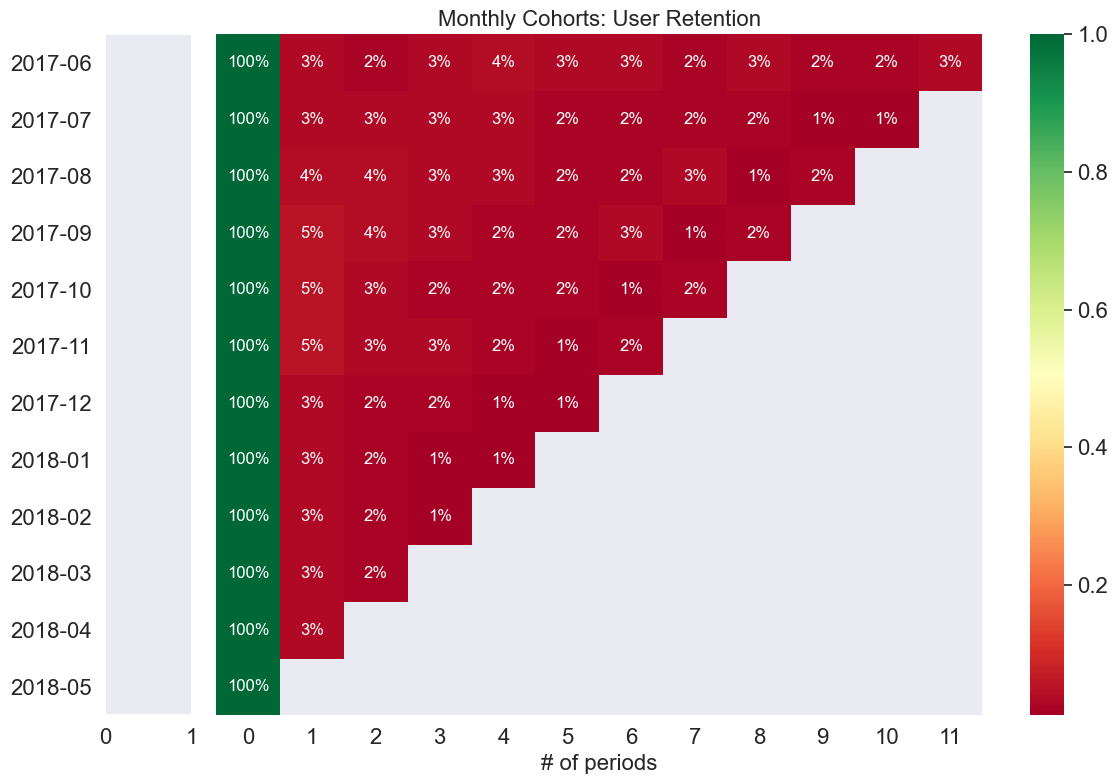

In [219]:
with sns.axes_style("dark"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    fig.tight_layout()

>***Conclusion:***
- The first-month retention rate decreases for each new cohort.
- The '09-2017' cohort has the highest retention rate.
- In 2018, the retention rate is significantly lower than in 2017.
- There was no retention in the '05-2018' cohort in the first month.

### 2.4 Sales

 `When do people start buying?`

Let' find the difference between `first_order_date` and `first_visits_date`

In [220]:
df_users['conversion_day'] = ((df_users['first_order_date'] - df_users['first_visit_date'])
                              / np.timedelta64(1, 'D'))

In [221]:
df_users['conversion_group'] = df_users['conversion_day'].apply(helpers.conversion_group)
df_users[['conversion_group_name', 'conversion_group_id']] = pd.DataFrame(df_users['conversion_group'].tolist(), index=df_users.index)

`Conversion Rate`

The conversion rate is the share of users who change their status during visit. So, let's calculate it:

In [222]:
_conversion_rate = (df_users.groupby(['conversion_group_name', 'conversion_group_id']).agg({
                       'buy_ts': 'count'
                       ,'session_start_ts': 'count'                       
                   })
                   .reset_index()
                   .sort_values(by='conversion_group_id', ascending=True)
                   .rename(columns={
                       'uid': 'n_users'
                       ,'session_start_ts': 'n_sessions'
                       ,'buy_ts': 'n_orders'
                       })
                    )
_conversion_rate['conversion_%'] = (_conversion_rate['n_orders'] / _conversion_rate['n_sessions'] * 100).round(2)

_conversion_rate

,conversion_group_name,conversion_group_id,n_orders,n_sessions,conversion_%
0,0 d,0,32334,49872,64.83
5,7 d,1,7033,20014,35.14
1,14 d,2,1648,4781,34.47
2,30 d,3,2179,7647,28.49
3,45 d,4,1155,4724,24.45
4,60 d,5,895,3310,27.04
7,more than 60 d,6,5170,21533,24.01
6,Never bought,7,0,261999,0.00


Why is the conversion rate so high?

This occurs when a visitor’s conversion takes place on your landing page during a time period later than the time of their visit. In this particular case, our analytics will display the visit and the conversion with different timestamps and therefore, for a particular period of time, you will see a conversion rate of over 100%.

https://help.instapage.com/hc/en-us/articles/115010682767-Why-is-my-conversion-rate-over-100-

In [223]:
fig = px.bar(
    _conversion_rate
    ,x='conversion_group_name'
    ,y='conversion_%'
    ,title='CR - Conversion Rate by categories, %'
    ,labels={'conversion_%': ''
             ,'conversion_group_name': ''
             }
    ,text='conversion_%'
)
# fig.update_xaxes(showline=False, showgrid=False)
fig.update_yaxes(showline=False, showgrid=False)

`Conversion Rate over time`

In [224]:
at_users_daily['conversion_rate_%'] = (at_users_daily['orders_count'] / at_users_daily['sessions_count'] * 100).round(2)

In [225]:
avg_daily_conversion_rate = at_users_daily['conversion_rate_%'].mean().round(2)
avg_daily_conversion_rate

13.13

In [226]:
fig = px.line(
    at_users_daily
    ,x='visit_date'
    ,y='conversion_rate_%'
    ,title='Conversion rate % over time'
    ,labels={
        'visit_date': ''
        ,'conversion_rate_%': ''
    }
)
fig.add_hline(y=avg_daily_conversion_rate)\
    .update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

# fig.show()

`Average Convertion Rate by weekdays`

In [227]:
_tmp_conversion_weekday = at_users_daily.groupby(['visit_year', 'visit_weekday', 'weekday_num'])\
    .agg({
        'conversion_rate_%': 'mean'
    })\
        .reset_index()\
            .rename(columns={'conversion_rate_%': 'conversion_rate_mean'})\
                .sort_values(by=['visit_year', 'weekday_num']) 

_tmp_conversion_weekday['conversion_rate_mean'] = _tmp_conversion_weekday['conversion_rate_mean'].round(2)
_tmp_conversion_weekday

,visit_year,visit_weekday,weekday_num,conversion_rate_mean
1,2017,Monday,0,12.18
5,2017,Tuesday,1,13.06
6,2017,Wednesday,2,13.27
4,2017,Thursday,3,13.05
0,2017,Friday,4,14.23
2,2017,Saturday,5,13.71
3,2017,Sunday,6,12.27
8,2018,Monday,0,12.98
12,2018,Tuesday,1,12.90
13,2018,Wednesday,2,13.64


In [228]:
fig = px.bar(
    _tmp_conversion_weekday
    ,x='visit_weekday'
    ,y='conversion_rate_mean'
    ,title='Average Conversion Rate by weekday'
    ,labels={
        'visit_weekday': ''
        ,'conversion_rate_mean': ''
    }
    ,color='visit_year'
    ,barmode='group'
    ,text='conversion_rate_mean'
)
fig.add_hline(y=avg_daily_conversion_rate)\
    .update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

>***Conclusion:***
- Most often, users make their first purchase on the day of their first visit. The conversion on the first day of the user visit is almost 65%.
- Over the next 7 days and 30 days, the conversion dropped sharply
- 70.08% of visitors have never bought
- The conversion rate is not significantly affected by weekdays
- On Monday and Thursday the conversion rate drops below the average conversion.


### 2.5 Orders

`Number of Orders vs DAU over time`

In [229]:
fig = px.line(
    at_users_daily
    ,x='visit_date'
    ,y=['orders_count', 'dau']
    ,title='Number of orders vs DAU over time'
    ,labels={
        'visit_day': ''
        ,'orders_count': ''
    } 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Average number of orders per user over time`

In [230]:
fig = px.line(
    at_users_daily
    ,x='visit_date'
    ,y='num_orders_per_user_mean'
    ,title='Average number of orders per user over time'
    ,labels={
        'visit_date': ''
        ,'num_orders_per_user_mean': ''
    }
 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Average number of orders by weekday`

In [231]:
_tmp_orders_weekday = at_users_daily.groupby(['visit_year', 'visit_weekday', 'weekday_num'])\
    .agg({
        'orders_count': 'mean'
    })\
        .reset_index()\
            .rename(columns={'orders_count': 'n_orders_mean'})\
                .sort_values(by=['visit_year', 'weekday_num']) 

_tmp_orders_weekday['n_orders_mean'] = _tmp_orders_weekday['n_orders_mean'].astype(int)
_tmp_orders_weekday

,visit_year,visit_weekday,weekday_num,n_orders_mean
1,2017,Monday,0,131
5,2017,Tuesday,1,135
6,2017,Wednesday,2,131
4,2017,Thursday,3,136
0,2017,Friday,4,160
2,2017,Saturday,5,110
3,2017,Sunday,6,92
8,2018,Monday,0,161
12,2018,Tuesday,1,157
13,2018,Wednesday,2,162


In [232]:
fig = px.bar(
    _tmp_orders_weekday
    ,x='visit_weekday'
    ,y='n_orders_mean'
    ,title='Average number of orders by weekday'
    ,labels={
        'visit_weekday': ''
        ,'n_orders_mean': ''
    }
    ,color='visit_year'
    ,barmode='group'
    ,text='n_orders_mean'
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Number of orders by device over time`

In [233]:
_orders_monthly_by_device = df_users.groupby(['visit_year', 'visit_month', 'device'])\
    .agg({
        'uid': 'nunique'
        ,'buy_ts': 'count'
    })\
    .reset_index().rename(columns = {'uid': 'nunique_users', 'buy_ts': 'n_orders'})
_orders_monthly_by_device

,visit_year,visit_month,device,nunique_users,n_orders
0,2017,2017-06-01,browser,9761,1704
1,2017,2017-06-01,mobile,3655,284
2,2017,2017-06-01,unknown,315,367
3,2017,2017-07-01,browser,10145,1500
4,2017,2017-07-01,mobile,4223,331
...,...,...,...,...,...
67,2018,2018-04-01,mobile,6387,347
68,2018,2018-04-01,unknown,872,1053
69,2018,2018-05-01,browser,14308,2469
70,2018,2018-05-01,mobile,6645,505


In [234]:
fig = px.bar(
    _orders_monthly_by_device
    ,x='visit_month'
    ,y='n_orders'
    ,title='Monthly number of orders by device'
    ,labels={
        'device': ''
        ,'n_orders': ''
        ,'visit_month': ''
    }
    ,color='device'
    ,barmode='stack'
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Average number of orders by source Id`

In [235]:
_orders_monthly_by_sourse_id = df_users.groupby(['visit_year', 'visit_month', 'source_id'])\
    .agg({
        'uid': 'nunique'
        ,'buy_ts': 'count'
    })\
    .reset_index().rename(columns = {'uid': 'nunique_users', 'buy_ts': 'n_orders'})
_orders_monthly_by_sourse_id

,visit_year,visit_month,source_id,nunique_users,n_orders
0,2017,2017-06-01,0,315,367
1,2017,2017-06-01,1,972,270
2,2017,2017-06-01,2,1532,254
3,2017,2017-06-01,3,4226,549
4,2017,2017-06-01,4,3636,371
...,...,...,...,...,...
109,2018,2018-05-01,4,7274,642
110,2018,2018-05-01,5,4036,666
111,2018,2018-05-01,7,2,0
112,2018,2018-05-01,9,753,42


In [236]:
fig = px.area(
    _orders_monthly_by_sourse_id
    ,x='visit_month'
    ,y='n_orders'
    ,title='Monthly number of orders by device'
    ,labels={
        'source_id': ''
        ,'n_orders': ''
        ,'visit_month': ''
    }
    ,color='source_id'
    # ,barmode='stack'
    # ,text='n_orders_mean'
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

### 2.6 Create Monthly Analytical Table

In [237]:
# list(df_users.columns)

In [238]:
at_users_monthly = df_users.groupby(['visit_year', 'visit_month'])\
    .agg({
        'uid': 'nunique'
        ,'session_start_ts': 'count'
        ,'session_duration_sec': 'sum'
        ,'buy_ts': 'count'
        ,'is_new_user': 'sum'
        ,'is_new_buyer': 'sum'
        ,'revenue': 'sum'
        
    })\
        .reset_index()\
            .rename(columns={
                'uid': 'mau'
                ,'session_start_ts': 'sessions_count'
                ,'session_duration_sec': 'sessions_duration_total_sec'
                ,'buy_ts': 'orders_count'
                ,'is_new_user': 'new_users'
                ,'is_new_buyer': 'new_buyers'
                ,'revenue': 'revenue_total'})
at_users_monthly

,visit_year,visit_month,mau,sessions_count,sessions_duration_total_sec,orders_count,new_users,new_buyers,revenue_total
0,2017,2017-06-01,13259,16872,7422038,2355,13259,2024,7028.38
1,2017,2017-07-01,14237,18359,7991135,2362,13140,1922,8438.28
2,2017,2017-08-01,11709,14824,6314203,1808,10181,1371,6429.64
3,2017,2017-09-01,19111,24817,10979312,3387,16704,2580,11014.79
4,2017,2017-10-01,29901,39331,17561346,5678,25977,4340,17949.57
5,2017,2017-11-01,33055,45697,20885279,5659,27248,4081,18160.67
6,2017,2017-12-01,31898,43833,20066995,6218,25268,4383,19950.12
7,2018,2018-01-01,29064,38322,17056589,4723,22624,3375,14711.40
8,2018,2018-02-01,29149,38816,17219922,5280,22197,3650,17288.16
9,2018,2018-03-01,27911,37443,16721977,5325,20590,3532,16986.34


Add marketing metrics

Add  `profit` and `profit_cum` variables to monthly analytical table

*There is no margin information in the project description. But to complete the task, let's take into account the average sales margin of 50%*

In [239]:
at_users_monthly['profit'] = (at_users_monthly['revenue_total'] * 0.5).round(2)
at_users_monthly['profit_cum'] = at_users_monthly['profit'].cumsum()
# at_users_monthly['profit_lag'] = at_users_monthly['profit'].shift(1)

`Monthly Conversion Rate`

In [240]:
at_users_monthly['conversion_rate_%'] = (at_users_monthly['orders_count'] / at_users_monthly['sessions_count'] * 100).round(2)

`CLTV - Customer Lifetime Value Metrics`

https://blog.hubspot.com/service/how-to-calculate-customer-lifetime-value

- AOV - Average Order Value
- AOFR - Average Order Frequency Rate
- CV - Customer (User) Value
- ACLS - Average Customer Lifespan
- CLTV - Customer Lifetime Value - Customer Lifetime Value = (Customer Value * Average Customer Lifespan)

In [241]:
at_users_monthly['avg_order_value'] = (at_users_monthly['revenue_total'] / at_users_monthly['orders_count'] ).round(2)
at_users_monthly['avr_order_frequency_rate'] = (at_users_monthly['orders_count'] / at_users_monthly['mau'] ).round(2)
at_users_monthly['customer_value'] = (at_users_monthly['avg_order_value'] * at_users_monthly['avr_order_frequency_rate'] ).round(2)
at_users_monthly['avg_customer_lifetime_span'] = (at_users_monthly['revenue_total'] / at_users_monthly['mau'] ).round(2)
at_users_monthly['avg_customer_ltv_cum'] = (at_users_monthly['customer_value'] * at_users_monthly['avg_customer_lifetime_span'] ).cumsum().round(2)

In [242]:
at_users_monthly

,visit_year,visit_month,mau,sessions_count,sessions_duration_total_sec,orders_count,new_users,new_buyers,revenue_total,profit,profit_cum,conversion_rate_%,avg_order_value,avr_order_frequency_rate,customer_value,avg_customer_lifetime_span,avg_customer_ltv_cum
0,2017,2017-06-01,13259,16872,7422038,2355,13259,2024,7028.38,3514.19,3514.19,13.96,2.98,0.18,0.54,0.53,0.29
1,2017,2017-07-01,14237,18359,7991135,2362,13140,1922,8438.28,4219.14,7733.33,12.87,3.57,0.17,0.61,0.59,0.65
2,2017,2017-08-01,11709,14824,6314203,1808,10181,1371,6429.64,3214.82,10948.15,12.20,3.56,0.15,0.53,0.55,0.94
3,2017,2017-09-01,19111,24817,10979312,3387,16704,2580,11014.79,5507.40,16455.55,13.65,3.25,0.18,0.58,0.58,1.27
4,2017,2017-10-01,29901,39331,17561346,5678,25977,4340,17949.57,8974.78,25430.33,14.44,3.16,0.19,0.60,0.60,1.63
5,2017,2017-11-01,33055,45697,20885279,5659,27248,4081,18160.67,9080.33,34510.66,12.38,3.21,0.17,0.55,0.55,1.94
6,2017,2017-12-01,31898,43833,20066995,6218,25268,4383,19950.12,9975.06,44485.72,14.19,3.21,0.19,0.61,0.63,2.32
7,2018,2018-01-01,29064,38322,17056589,4723,22624,3375,14711.40,7355.70,51841.42,12.32,3.11,0.16,0.50,0.51,2.58
8,2018,2018-02-01,29149,38816,17219922,5280,22197,3650,17288.16,8644.08,60485.50,13.60,3.27,0.18,0.59,0.59,2.92
9,2018,2018-03-01,27911,37443,16721977,5325,20590,3532,16986.34,8493.17,68978.67,14.22,3.19,0.19,0.61,0.61,3.30


In [243]:
avg_order_value_mean = at_users_monthly['avg_order_value'].mean().round(2)
avg_order_value_mean

3.25

`Profit vs Profit cumulative`

In [244]:
fig = px.line(
    at_users_monthly
    ,x='visit_month'
    ,y=['profit', 'profit_cum']
    ,title='Profit over time'
    ,labels={
        'visit_month': ''
        ,'orders_count': ''
        ,'value': ''
        ,'variable': ''
    }
 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Number of monthly orders`

In [245]:
fig = px.bar(
    at_users_monthly
    ,x='visit_month'
    ,y='orders_count'
    ,title='Monthly number of orders'
    ,labels={
        'visit_month': ''
        ,'orders_count': ''
    }
    ,text='orders_count'
 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Average Order Value over time`

In [246]:
avg_order_value_mean = at_users_monthly['avg_order_value'].mean()
avg_order_value_mean

3.2458333333333336

In [247]:
fig = px.bar(
    at_users_monthly
    ,x='visit_month'
    ,y='avg_order_value'
    ,title='Average Order Value over time'
    ,labels={
        'visit_month': ''
        ,'avg_order_value': ''
    }
    ,text='avg_order_value'
     
)
fig.add_hline(y=avg_order_value_mean)\
    .update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

>Conclusion

- The maximum number of orders per day is 819 and the minimum is 0. From the line graph, we can see that the daily number of orders depends on the DAU.
- It is clear that the more visitors are attracted daily, the more orders we have.
- The number of orders fluctuates based on the month and season.
- According to the data, December 2017 was the most profitable month with a total of 6218 orders.
- The number of orders verises depending on the month.
- At the same time, the average monthly order values are higher than their average values only for 3 months - June, July 2017, and April 2018.

### 2.7 Marketing

In [248]:
df_costs = pd.read_csv(os.path.join(source_dir, file_costs)
                      #  ,nrows=500
                       ,parse_dates=['costs_date']
                    #    ,dtype={'device': 'category', 'source_id': 'int'}
                       )

In [249]:
df_costs.info()
# df_costs.head()
# df_costs.tail()
df_costs.sample(5)
df_costs.nunique()
# df_costs.duplicated().mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   source_id   2542 non-null   int64         
 1   costs_date  2542 non-null   datetime64[ns]
 2   costs       2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


,source_id,costs_date,costs
185,1,2017-12-03,69.72
301,1,2018-03-29,40.00
2334,10,2017-11-03,36.51
1851,9,2017-07-06,13.52
2042,9,2018-01-13,16.15


source_id        7
costs_date     364
costs         2396
dtype: int64

`How much money was spent - Overall?`

In [250]:
df_costs['costs'].sum()
df_costs['costs'].mean().round(2)

df_costs.groupby('costs_date')['costs'].sum().mean().round(2)


329131.62

129.48

904.21

`How much money was spent - Per source overall?`

In [251]:
_costs_per_source_total = df_costs.groupby('source_id')\
    .agg({
        'costs': ['sum', 'mean']
        })\
        .reset_index()
_costs_per_source_total.columns = _costs_per_source_total.columns.map('_'.join)
# _costs_per_source_total.columns['costs_mean'] = _costs_per_source_total.columns['costs_mean'].round(2)
_costs_per_source_total

,source_id_,costs_sum,costs_mean
0,1,20833.27,57.391928
1,2,42806.04,117.922975
2,3,141321.63,389.315785
3,4,61073.60,168.246832
4,5,51757.10,142.189835
5,9,5517.49,15.199697
6,10,5822.49,16.039917


In [252]:
fig = px.bar(
    _costs_per_source_total
    ,x='source_id_'
    ,y='costs_sum'
    ,title='Costs per source Id overall'
    ,labels={
        'source_id_': ''
        ,'costs_sum': ''
    }
    ,text='costs_sum'
 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Tracking Daily Expenses Over Time`

In [253]:
_costs_daily = df_costs.groupby('costs_date')['costs'].sum().reset_index()
_costs_daily.head()

,costs_date,costs
0,2017-06-01,735.26
1,2017-06-02,721.19
2,2017-06-03,450.85
3,2017-06-04,761.16
4,2017-06-05,821.44


In [254]:
fig = px.line(
    _costs_daily
    ,x='costs_date'
    ,y='costs'
    ,title='Daily money spent over time'
    ,labels={
        'costs_date': ''
        ,'costs': ''
    }
 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`Tracking Monthly Expenses Over Time by Source Id`

In [255]:
df_costs['costs_month'] = helpers.get_month(df_costs['costs_date'])
df_costs['costs_year'] = df_costs['costs_date'].dt.isocalendar().year

In [256]:
_costs_monthly_by_source_id = df_costs.groupby(['costs_year', 'costs_month', 'source_id'])\
    ['costs'].sum().reset_index()
_costs_monthly_by_source_id

,costs_year,costs_month,source_id,costs
0,2017,2017-06-01,1,1125.61
1,2017,2017-06-01,2,2427.38
2,2017,2017-06-01,3,7731.65
3,2017,2017-06-01,4,3514.80
4,2017,2017-06-01,5,2616.12
...,...,...,...,...
79,2018,2018-05-01,3,9411.42
80,2018,2018-05-01,4,4214.21
81,2018,2018-05-01,5,3669.56
82,2018,2018-05-01,9,362.17


In [257]:
fig = px.area(
    _costs_monthly_by_source_id
    ,x='costs_month'
    ,y='costs'
    ,title='Monthly Marketing costs over time by source Id'
    ,labels={
        'costs_month': ''
        ,'costs': ''
        ,'source_id': 'Source Id'
    }
    ,color='source_id'
 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

>***Conclusion:***

- There are 7 sources Id
- Total spends is 329131.62
- Average daily costs are 904.21
- Average monthly costs are 14790.5 and range from minimum (14790.5) in August 2017 to maximum (30487.6) in January 2018.
- The most expensive `source_id`  is 3rd, the less expensive - 9th, and 10th.

`Monthly acquisition cost by Source Id`

In [258]:
at_users_monthly_by_source_id = df_users.groupby(['visit_year', 'visit_month', 'source_id'])\
    .agg({
        'uid': 'nunique'
        ,'session_start_ts': 'count'
        ,'buy_ts': 'count'
        ,'revenue': 'sum'
        ,'is_new_user': 'sum'
        ,'is_new_buyer': 'sum'        
    })\
        .reset_index()\
            .rename(columns = {
                'uid': 'nunique_users'
                ,'session_start_ts': 'sessions_count'
                ,'buy_ts': 'orders_count'
                ,'revenue': 'revenue_sum'
                ,'is_new_user': 'new_users'
                ,'is_new_buyer': 'new_buyers' 
            })
at_users_monthly_by_source_id.head()


,visit_year,visit_month,source_id,nunique_users,sessions_count,orders_count,revenue_sum,new_users,new_buyers
0,2017,2017-06-01,0,315,367,367,1150.33,0,220
1,2017,2017-06-01,1,972,1544,270,886.05,631,226
2,2017,2017-06-01,2,1532,2191,254,715.96,1262,209
3,2017,2017-06-01,3,4226,4435,549,1481.28,4080,531
4,2017,2017-06-01,4,3636,3911,371,1055.95,3447,343


In [259]:
report_cac = at_users_monthly_by_source_id.merge(_costs_monthly_by_source_id, how='left'
                                  ,left_on=['visit_year', 'visit_month', 'source_id']
                                  ,right_on=['costs_year', 'costs_month', 'source_id']
                                  )

In [260]:
report_cac.sample(5)

,visit_year,visit_month,source_id,nunique_users,sessions_count,orders_count,revenue_sum,new_users,new_buyers,costs_year,costs_month,costs
13,2017,2017-07-01,4,4114,4402,414,1476.83,3647,384,2017,2017-07-01,3529.73
0,2017,2017-06-01,0,315,367,367,1150.33,0,220,<NA>,NaT,NaN
28,2017,2017-08-01,10,244,269,38,72.85,211,34,2017,2017-08-01,232.57
54,2017,2017-11-01,6,1,1,0,0.00,1,0,<NA>,NaT,NaN
61,2017,2017-12-01,3,9194,9724,977,3007.67,7437,883,2017,2017-12-01,16219.52


`Calculating CAC - customer acquisition costs`

Customer Acquisition Cost = Cost of Sales and Marketing divided by the Number of New Customers Acquired.

https://blog.hubspot.com/service/what-does-cac-stand-for

In [261]:
report_cac['cac'] = (report_cac['costs'] / report_cac['new_users']).round(2)

In [262]:
fig = px.bar(
    report_cac
    ,x='costs_month'
    ,y='cac'
    ,title='CAC - customer acquisition costs by source Id'
    ,labels={
        'visit_month': ''
        ,'cac': ''
        ,'source_id': ''
        ,'costs_month': ''
    }
    ,color='source_id'
    ,barmode='group'
 
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`LTV vs CAC ratio`

In [263]:
df_costs_monthly = df_costs.groupby(['costs_year', 'costs_month'])['costs']\
    .sum().reset_index().rename(columns = {'costs': 'costs_total'})

In [264]:
at_users_monthly = at_users_monthly.merge(df_costs_monthly
                                          ,how='left'
                                          ,left_on=['visit_year', 'visit_month']
                                          ,right_on=['costs_year', 'costs_month']
                                          )

In [265]:
at_users_monthly['cac'] = (at_users_monthly['costs_total'] / at_users_monthly['new_users'])\
    .round(2)

In [266]:
at_users_monthly['ltv_cac_ratio'] = (at_users_monthly['avg_customer_ltv_cum'] / at_users_monthly['cac'])\
    .round(2)

In [267]:
fig = px.bar(
    at_users_monthly
    ,x='visit_month'
    ,y='ltv_cac_ratio'
    ,title='LTV vs CAC ratio'
    ,labels={
        'visit_month': ''
        ,'ltv_cac_ratio': ''
    }
    ,text='ltv_cac_ratio'
)
fig.add_hline(y=3)\
    .update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

*Ideally, LTV: CAC ratio should be 3:1 — in other words, the value of your customers should be three times the cost of acquiring them.*

`Churn Rate`

Churn Rate = (Users at the beginning of the month - Users at the end of the month) / by Users at the beginning of the month

https://www.zoho.com/subscriptions/guides/what-is-customer-lifetime-value-clv.html#:~:text=Average%20Customer%20Lifespan%20(ACL)%20is,the%20total%20number%20of%20customers.

The other appoach - What is churn rate in ecommerce?
A churn rate is the percentage of your existing customers who do not reorder.

https://www.shopify.com/blog/churn-rate-in-ecommerce#:~:text=What%20is%20churn%20rate%20in,a%20customer%20won't%20return.

Generally, a lower churn rate is better, as it means more customers are reordering

In [268]:
at_users_monthly['mau_previous'] = at_users_monthly['mau'].shift(1)

# The first approach
# at_users_monthly['churn_rate'] = ((at_users_monthly['mau_previous'] - at_users_monthly['mau']) / at_users_monthly['mau_previous']).round(2)


# The second approach
at_users_monthly['churn_rate'] = (at_users_monthly['orders_count'] / at_users_monthly['mau_previous'] * 100).round(2)

In [269]:
fig = px.bar(
    at_users_monthly
    ,x='visit_month'
    ,y='churn_rate'
    ,title='Churn Rate'
    ,labels={
        'visit_month': ''
        ,'churn_rate': ''
    }
    ,text='churn_rate'
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`ROMI - Return on Marketing Investment`

ROMI = (Revenue - Marketing Expenses) / Marketing Expenses

https://www.dashly.io/blog/roi-formula/

In [270]:
at_users_monthly['romi'] = ((at_users_monthly['revenue_total'] - at_users_monthly['costs_total']) /at_users_monthly['costs_total'] * 100).round(2)

In [271]:
fig = px.bar(
    at_users_monthly
    ,x='visit_month'
    ,y='romi'
    ,title='Monthly ROMI - Return on Marketing Investment'
    ,labels={
        'visit_month': ''
        ,'romi': ''
    }
    ,text='romi'
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

`ROAS - the Return Ratio of your Advertising Spend`

ROAS = Revenue Total / Advertising Total Costs

In [272]:
at_users_monthly['roas'] = (at_users_monthly['revenue_total']  / at_users_monthly['costs_total'] * 100).round(2)

In [273]:
fig = px.bar(
    at_users_monthly
    ,x='visit_month'
    ,y='roas'
    ,title='Monthly ROAS - the Return Ratio of Advertising Spend'
    ,labels={
        'visit_month': ''
        ,'roas': ''
    }
    ,text='roas'
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

In [274]:
fig = px.bar(
    at_users_monthly
    ,x='visit_month'
    ,y=['revenue_total', 'costs_total']
    ,title='Revenue vs Costs, monthly'
    ,labels={
        'variable': ''
        ,'value': ''
        ,'revenue_total': 'Revenue Total'
        ,'costs_total': 'Costs Total'
        ,'visit_month': ''
    }
    ,barmode='group'
)
fig.update_yaxes(showgrid=False)\
    .update_xaxes(showgrid=False)\
        .update_traces(textangle=1, selector=dict(type='bar'), textfont_color='white')

In [275]:
at_users_monthly

,visit_year,visit_month,mau,sessions_count,sessions_duration_total_sec,orders_count,new_users,new_buyers,revenue_total,profit,profit_cum,conversion_rate_%,avg_order_value,avr_order_frequency_rate,customer_value,avg_customer_lifetime_span,avg_customer_ltv_cum,costs_year,costs_month,costs_total,cac,ltv_cac_ratio,mau_previous,churn_rate,romi,roas
0,2017,2017-06-01,13259,16872,7422038,2355,13259,2024,7028.38,3514.19,3514.19,13.96,2.98,0.18,0.54,0.53,0.29,2017,2017-06-01,18015.00,1.36,0.21,NaN,NaN,-60.99,39.01
1,2017,2017-07-01,14237,18359,7991135,2362,13140,1922,8438.28,4219.14,7733.33,12.87,3.57,0.17,0.61,0.59,0.65,2017,2017-07-01,18240.59,1.39,0.47,13259.0,17.81,-53.74,46.26
2,2017,2017-08-01,11709,14824,6314203,1808,10181,1371,6429.64,3214.82,10948.15,12.20,3.56,0.15,0.53,0.55,0.94,2017,2017-08-01,14790.54,1.45,0.65,14237.0,12.70,-56.53,43.47
3,2017,2017-09-01,19111,24817,10979312,3387,16704,2580,11014.79,5507.40,16455.55,13.65,3.25,0.18,0.58,0.58,1.27,2017,2017-09-01,24368.91,1.46,0.87,11709.0,28.93,-54.80,45.20
4,2017,2017-10-01,29901,39331,17561346,5678,25977,4340,17949.57,8974.78,25430.33,14.44,3.16,0.19,0.60,0.60,1.63,2017,2017-10-01,36322.88,1.40,1.16,19111.0,29.71,-50.58,49.42
5,2017,2017-11-01,33055,45697,20885279,5659,27248,4081,18160.67,9080.33,34510.66,12.38,3.21,0.17,0.55,0.55,1.94,2017,2017-11-01,37907.88,1.39,1.40,29901.0,18.93,-52.09,47.91
6,2017,2017-12-01,31898,43833,20066995,6218,25268,4383,19950.12,9975.06,44485.72,14.19,3.21,0.19,0.61,0.63,2.32,2017,2017-12-01,38315.35,1.52,1.53,33055.0,18.81,-47.93,52.07
7,2018,2018-01-01,29064,38322,17056589,4723,22624,3375,14711.40,7355.70,51841.42,12.32,3.11,0.16,0.50,0.51,2.58,2018,2018-01-01,33518.52,1.48,1.74,31898.0,14.81,-56.11,43.89
8,2018,2018-02-01,29149,38816,17219922,5280,22197,3650,17288.16,8644.08,60485.50,13.60,3.27,0.18,0.59,0.59,2.92,2018,2018-02-01,32723.03,1.47,1.99,29064.0,18.17,-47.17,52.83
9,2018,2018-03-01,27911,37443,16721977,5325,20590,3532,16986.34,8493.17,68978.67,14.22,3.19,0.19,0.61,0.61,3.30,2018,2018-03-01,30415.27,1.48,2.23,29149.0,18.27,-44.15,55.85


>Conclusion

- The CAC depends on the `source_id`.
- The most expensive sources are 1, 2 and 3.
- The biggest season dependency 2nd and 3rd source Id has.
- Ideally, LTV: CAC ratio should be 3:1 — in other words, the value of your customers should be three times the cost of acquiring them. However we see that this ratio is less than 1.
- Revenue does not cover the costs of advertising. 
- Each month, the ROMI (Return on Marketing Investment) has negative values due to advertising costs exceeding revenue.
- ROAS - The Return Ratio of Advertising Spends is less than 60%

### 2.8 Save Analytical tables for daily and monthly user activities

In [276]:
df_users.sample(5)

,uid,device,source_id,session_start_ts,session_end_ts,buy_ts,revenue,session_duration_sec,first_session_ts,visit_date,first_visit_date,first_buy_ts,order_date,first_order_date,is_new_user,is_new_buyer,is_bought,session_dur_category,session_category_name,time_diff_1st_visit_1st_puchase_sec,revenue_mean,revenue_category,visit_weekday,weekday_num,visit_week_num,week_start_monday,visit_month,visit_year,order_month,cohort_month,conversion_day,conversion_group,conversion_group_name,conversion_group_id
314911,13845852774995066016,browser,3,2018-04-03 23:09:00,2018-04-03 23:12:00,NaT,0.00,180,2018-04-03 23:09:00,2018-04-03,2018-04-03,NaT,NaT,NaT,1,0,0,"[60.0, 240.0)",between 1 and 4 minutes,NaN,0.434,"(-inf, 0.0]",Tuesday,1,14,2018-04-02,2018-04-01,2018,NaT,NaT,NaN,"(Never bought, 7)",Never bought,7
364662,7854006831756916266,unknown,0,2017-11-28 19:41:00,2017-11-28 19:41:00,2017-11-28 19:41:00,2.75,0,2017-11-22 17:06:00,2017-11-28,2017-11-22,2017-11-28 19:41:00,2017-11-28,2017-11-28,0,1,1,"[0.0, 60.0)",up to 1 minute,9300.0,0.434,"(2.44, 4.28]",Tuesday,1,48,2017-11-27,2017-11-01,2017,2017-11,2017-11,6.0,"(7 d, 1)",7 d,1
341760,6645643859182613978,browser,5,2017-12-04 11:23:00,2017-12-04 11:30:00,NaT,0.00,420,2017-12-04 11:23:00,2017-12-04,2017-12-04,2017-12-04 14:29:00,NaT,2017-12-04,1,0,0,"[240.0, 444.16)",between 4 and 7.4 minutes,11160.0,0.434,"(-inf, 0.0]",Monday,0,49,2017-12-04,2017-12-01,2017,NaT,2017-12,0.0,"(0 d, 0)",0 d,0
48121,396260132288443034,mobile,4,2017-11-10 13:36:00,2017-11-10 13:39:00,NaT,0.00,180,2017-11-10 13:36:00,2017-11-10,2017-11-10,NaT,NaT,NaT,1,0,0,"[60.0, 240.0)",between 1 and 4 minutes,NaN,0.434,"(-inf, 0.0]",Friday,4,45,2017-11-06,2017-11-01,2017,NaT,NaT,NaN,"(Never bought, 7)",Never bought,7
252012,293094873313340571,browser,4,2018-02-21 23:08:00,2018-02-21 23:09:00,NaT,0.00,60,2018-01-30 15:23:00,2018-02-21,2018-01-30,NaT,NaT,NaT,0,0,0,"[60.0, 240.0)",between 1 and 4 minutes,NaN,0.434,"(-inf, 0.0]",Wednesday,2,8,2018-02-19,2018-02-01,2018,NaT,NaT,NaN,"(Never bought, 7)",Never bought,7


In [280]:
df_users.columns

Index(['uid', 'device', 'source_id', 'session_start_ts', 'session_end_ts', 'buy_ts', 'revenue', 'session_duration_sec', 'first_session_ts', 'visit_date', 'first_visit_date', 'first_buy_ts', 'order_date', 'first_order_date', 'is_new_user', 'is_new_buyer', 'is_bought', 'session_dur_category', 'session_category_name', 'time_diff_1st_visit_1st_puchase_sec', 'revenue_mean', 'revenue_category', 'visit_weekday', 'weekday_num', 'visit_week_num', 'week_start_monday', 'visit_month', 'visit_year', 'order_month', 'cohort_month', 'conversion_day', 'conversion_group', 'conversion_group_name', 'conversion_group_id'], dtype='object')

In [282]:
users_tbl_for_dashboard = df_users.drop([
    'revenue_mean', 
    'visit_weekday', 
    'weekday_num', 
    'visit_week_num', 
    'week_start_monday', 
    'visit_month', 
    'visit_year', 
    'order_month', 
    'cohort_month', 
    'conversion_day', 
    'conversion_group_name', 
    'conversion_group_id'
    
    ], axis = 1)

In [283]:
path_to_save = './reports/'
file_users_tbl_for_dashboard = 'users_tbl_for_dashboard.csv'
file_costs_tbl = 'costs_tbl.csv'
file_at_users_daily = 'at_users_daily.csv'
file_at_users_monthly = 'at_users_monthly.csv'

In [284]:
users_tbl_for_dashboard.to_csv(os.path.join(path_to_save, file_users_tbl_for_dashboard), sep=',', encoding='utf-8', index=False)
df_costs.to_csv(os.path.join(path_to_save, file_costs_tbl), sep=',', encoding='utf-8', index=False)

at_users_daily.to_csv(os.path.join(path_to_save, file_at_users_daily), sep=',', encoding='utf-8', index=False)
at_users_monthly.to_csv(os.path.join(path_to_save, file_at_users_monthly), sep=',', encoding='utf-8', index=False)

## Step 3. General conclusion

## End